In [ ]:

import scipy.spatial
from sklearn import manifold
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler

import numpy as np

import os


from itertools import permutations
from matplotlib import pyplot as plt
from matplotlib.pyplot import triplot
from numpy import pi,sin,cos,tan,sqrt
from IPython.core.debugger import Tracer

import triangle as tri
import triangle
import triangle.plot as plot


from scipy.spatial import ConvexHull
from matplotlib.path import Path

import pickle



import torch
import torch.optim as optim

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F



import cTimer as ctimer
import time
from timeit import default_timer as timer
import pickle

%matplotlib inline



In [ ]:
def BCE_accuracy(model,variable,labels):
    net.eval()
    predictions=model(variable).data.numpy()
    predictions[np.where(predictions>0.5)]=1
    predictions[np.where(predictions<=0.5)]=0
    diff=labels-predictions
    correct_prediction=0
    for i in diff:
        if (not i.any()):
            correct_prediction+=1
    net.train()
    return  100*correct_prediction/variable.size()[0],diff

def plot_contour(contour):    
    plot_coords=np.vstack([contour,contour[0]])
    (s,t)=zip(*plot_coords)
    plt.plot(s,t)
    indices=[i for i in range(contour.shape[0])]
    for index,i in enumerate(indices):
        plt.annotate(str(i),(s[index],t[index]))
    



def connectivity_information(triangulation,print_info=False):
    
    segments= tuple(triangulation['segments'].tolist())
    triangles=tuple(triangulation['triangles'].tolist())
    vertices=triangulation['vertices']   
    
    connect_info={str(r):[0 for i in range(len(vertices))] for r in tuple(triangulation['segments'].tolist())}
    for segment in segments:
        for triangle in triangles:
            if set(segment).issubset(set(triangle)):
                connection=set(triangle)-set(segment)
                if print_info: print("segment:",segment,"is connected to:",connection,"to form triangle:",triangle)
                connect_info[str(segment)][tuple(connection)[0]]=1    
    return connect_info



def get_labels(triangulation,connect_info):
    indices=[]
    vertices=list(range(triangulation['vertices'].shape[0]))
    for i in triangulation['segments']:
           indices.append(set(vertices)-set(i)) 
    labels=[]
    list_values=list(connect_info.values())
    for i in range(len(list_values)):
        for j in indices[i]:
            labels.append(list_values[i][j])
    return  labels


In [ ]:

def rot(theta):
    return np.array([[cos(theta),-sin(theta)],     
                     [sin(theta),cos(theta)]])






def get_reference_polygon(nb_of_points,plot=False):
    angles=np.empty(nb_of_points)
    points=np.empty([nb_of_points,2])
    plot_coords=np.empty([nb_of_points,2])
    indices=[]
    angle_division=2*pi/nb_of_points
   
    for i in range(nb_of_points):
        angle=i*angle_division
        angles[i]=angle
        point=np.array([1,0]) #pick edge length of 1
        points[i]=np.dot(rot(angle),point.T)  #rotate it according to the  chosen angle
        indices.append(i)
   
    if plot==True:
        plot_coords=np.vstack([points,points[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return points



def generate_contour(nb_of_points,plot=False):
    
    angles=np.empty(nb_of_points)
    points=np.empty([nb_of_points,2])
    plot_coords=np.empty([nb_of_points,2])
    indices=[]
    angle_division=2*pi/nb_of_points
   
    for i in range(nb_of_points):
        angle=((i+1)*angle_division-i*angle_division)*np.random.random_sample()+i*angle_division
        angles[i]=angle
        point=np.array([np.random.uniform(0.3,1),0]) #pick random point at (1,0)
       #point=np.array([1,0]) #pick edge length of 1

        points[i]=np.dot(rot(angle),point.T)  #rotate it according to the  chosen angle
        indices.append(i)
   
    if plot==True:
        plot_coords=np.vstack([points,points[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return points



def get_barycenter(contour):
    return np.array([contour[:,0].sum()/contour.shape[0],contour[:,1].sum()/contour.shape[0]])


def apply_procrustes(polygon_points,plot=False):  
    
    # Get reference polygona and adjust any random poygon to that
    ref_polygon=get_reference_polygon(polygon_points.shape[0])
    
    
    #Mean of each coordinate
    mu_polygon = polygon_points.mean(0)
    mu_ref_polygon = ref_polygon.mean(0)
    
    #Centralize data to the mean 
    centralised_ref_polygon_points = ref_polygon-mu_ref_polygon
    centralised_polygon_points = polygon_points-mu_polygon
    
    #Squared sum of X-mean(X)
    ss_ref_polygon_points = (centralised_ref_polygon_points**2.).sum()
    ss_polygon_points = (centralised_polygon_points**2.).sum()

       
    #Frobenius norm of X
    norm_ss_ref_polygon_points = np.sqrt(ss_ref_polygon_points)
    norm_ss_polygon_points = np.sqrt(ss_polygon_points)

    
    # scale to equal (unit) norm
    centralised_ref_polygon_points /=norm_ss_ref_polygon_points     
    centralised_polygon_points /=norm_ss_polygon_points
        
    
    #Finding best rotation to superimpose on regular triangle
    #Applying SVD to the  matrix 
    A = np.dot(centralised_ref_polygon_points.T, centralised_polygon_points)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V=Vt.T
    R = np.dot(V,U.T)
    
  
    traceTA = s.sum()
    d = 1 - traceTA**2
    b = traceTA * norm_ss_ref_polygon_points / norm_ss_polygon_points    
    indices=[i for i in range(polygon_points.shape[0])]
    
   

    polygon_transformed =norm_ss_ref_polygon_points*traceTA*np.dot(centralised_polygon_points,R)+mu_ref_polygon

    if plot==True:
        plot_coords=np.vstack([polygon_transformed,polygon_transformed[0]])
        (s,t)=zip(*plot_coords)
        plt.plot(s,t)
        for index,i in enumerate(indices):
            plt.annotate(str(i),(s[index],t[index]))
    
    return polygon_transformed
        
    

In [ ]:

def contains_points(triangle,polygon):
    hull=ConvexHull(triangle)
    hull_path=Path(triangle[hull.vertices])
    set_polygon=set(tuple(i) for i in polygon)
    set_triangle=set(tuple(i) for i in triangle)
    #print(set_polygon,set_triangle)
    difference=set_polygon-set_triangle
    
    if len(difference)==0:
        return False

    for i in difference:
        if hull_path.contains_point(i):
            return True
            break
    return False




def compute_edge_lengths(pt1,pt2):
    return np.linalg.norm(pt1-pt2)

def compute_edge_lengths2(triangle):
    edgelengths2=np.empty([2,3])
    for i in range(2):
        for j in range(i+1,3):
            eij=triangle[j]-triangle[i]
            edgelengths2[i][j]=np.dot(eij,eij)
    return edgelengths2
    


def compute_triangle_normals(triangle):
   
    e01=triangle[1]-triangle[0]
    e02=triangle[2]-triangle[0]
    
    e01_cross_e02=np.cross(e01,e02)
    
    return e01_cross_e02


def compute_triangle_area(triangle):
   
    e01=triangle[1]-triangle[0]
    e02=triangle[2]-triangle[0]
    
    e01_cross_e02=np.cross(e01,e02)
    
    # Omit triangles that are inverted (out of the domain)
    if e01_cross_e02<0:
        return 0
        
    
    e01_cross_e02_norm=np.linalg.norm(e01_cross_e02)

        
    return e01_cross_e02_norm/2

def compute_triangle_quality(triangle,polygon=None):
    
    if polygon is None:
        polygon=triangle
    
    # The incoming triangle has edged [p0,p1] which is an edge and p2 is the connection
    polygon_angles=get_polygon_angles(polygon)
    
    indices=[]


    for point in triangle: 
        for index,point_in_polygon in enumerate(polygon):
              if np.allclose(point,point_in_polygon):
                    indices.append(index)
                
    p0,p1,p2=indices[0],indices[1],indices[2]
    
    neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
    # Checking if edges of connected poiints form an angle bigger than the polygon angles
    if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
        or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
    ):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    factor=4/sqrt(3)
    area=compute_triangle_area(triangle)
   
    if area==0:
        return 0
    
    if contains_points(triangle,polygon):
        return 0
    
    
    
    #edgelengths=np.empty([triangle.shape[0],1])
    
    #for i,_ in enumerate(triangle):
     #   edgelengths[i]=compute_edge_length(triangle[i],triangle[(i+1)%3])
    
    #sum_edge_lengths=edgelengths.sum() 
    #factor=4/sqrt(3)*3/sum_edge_lengths
    
    sum_edge_lengths=0
    edge_length2=compute_edge_lengths2(triangle)
    for i in range(2):
        for j in range(i+1,3):
            sum_edge_lengths+=edge_length2[i][j]
    
    
    
    lrms=sqrt(sum_edge_lengths/3)
    lrms2=lrms**2
    quality=area/lrms2
    
    return quality*factor



def compute_minimum_quality_triangle(triangle,polygon=None,get_mean=False):
    if polygon is None:
        polygon=triangle
    
    # The incoming triangle has edged [p0,p1] which is an edge and p2 is the connection
    polygon_angles=get_polygon_angles(polygon)
    
    indices=[]


    for point in triangle: 
        for index,point_in_polygon in enumerate(polygon):
              if np.allclose(point,point_in_polygon):
                    indices.append(index)
                
    p0,p1,p2=indices[0],indices[1],indices[2]
    
    neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
    # Checking if edges of connected poiints form an angle bigger than the polygon angles
    if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
        or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
    ):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
        or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
        #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
        return 0
    
    area=compute_triangle_area(triangle)
   
    if area==0:
        return 0
    
    if contains_points(triangle,polygon):
        return 0
    
    triangles_in_mesh=[]
    triangles_in_mesh.append(triangle)
    contour_connectivity=get_contour_edges(polygon)
    contour_connectivity=np.vstack([contour_connectivity,[p0,p2],[p1,p2]])
    hole=np.array([(triangle.sum(0))/3])
    shape=dict(holes=hole,vertices=polygon,segments=contour_connectivity)
    t = tri.triangulate(shape, 'pq0')
    
    Invalid_triangulation=False

    try:   
        for triangle_index in t['triangles']:
            triangles_in_mesh.append(polygon[np.asarray([triangle_index])])
    except :
        print("Invalid triangulation",p0,p1,p2)
        Invalid_triangulation=True
        
    triangle_qualities=[]
    for triangle in triangles_in_mesh:
        triangle.resize(3,2)
        triangle_quality=compute_triangle_quality(triangle)
        triangle_qualities.append(triangle_quality)
    
    if Invalid_triangulation:
        mean_quality,minimum_quality=0,0
    else:
        triangle_qualities=np.array(triangle_qualities)
        mean_quality=triangle_qualities.mean()
        minimum_quality=triangle_qualities.min()

    

    if get_mean:
        return mean_quality
    else:
        return minimum_quality





# Quality of elements formed by connecting each edge with one of the other points of the contour

def quality_matrix(polygon,compute_minimum=True ,normalize=False,mean=False):
    polygon=apply_procrustes(polygon,False)

    contour_connectivity=np.array(list(tuple(i) for i in get_contour_edges(polygon)))
    
    
    
    
    quality_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])
    area_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])
    normals_matrix=np.zeros([contour_connectivity.shape[0],polygon.shape[0]])

    list_of_triangles=[]
    
    for index,edge in enumerate(contour_connectivity):
        # Not omitting non triangles because either way their quality is zero
        triangles_to_edge_indices=[[*edge,i] for i in range(polygon.shape[0]) ]
        
        

        #print(triangles_to_edge_indices)
        triangles_to_edge_indices=np.asarray(triangles_to_edge_indices)
        triangles=polygon[triangles_to_edge_indices]
        list_of_triangles.append(triangles)
        
    
    list_of_triangles=np.array(list_of_triangles)
    
    if compute_minimum:
        for i,triangles in enumerate(list_of_triangles):
            for j,triangle in enumerate(triangles):
                quality_matrix[i,j]=compute_minimum_quality_triangle(triangle,polygon)
    else:
         for i,triangles in enumerate(list_of_triangles):
            for j,triangle in enumerate(triangles):
                if mean:
                    quality_matrix[i,j]=compute_triangle_quality(triangle,polygon,get_mean=True)
                else: 
                    quality_matrix[i,j]=compute_triangle_quality(triangle,polygon)
    
            #area_matrix[i,j]=compute_triangle_area(triangle)
            #normals_matrix[i,j]=compute_triangle_normals(triangle)

            
    
    sum_of_qualities=quality_matrix.sum(1)

    if normalize is True:
        for i,_ in enumerate(quality_matrix):
            quality_matrix[i]/=sum_of_qualities[i]
    
    return quality_matrix,normals_matrix




    
    
    

In [ ]:
def check_edge_validity(edge,polygon,set_edges,interior_edges):        
    # Check if new edges are already in the set
    found_in_set=False
    found_in_interior_set=False
    for index in range(len(polygon)):
        occuring_index=index

        edge1,edge2=tuple(permutations((edge[0],index))),tuple(permutations((edge[1],index)))
        condition1= edge1[0] in set_edges or edge1[1] in set_edges
        condition2= edge2[0] in set_edges or edge2[1] in set_edges
        condition3= edge1[0] in interior_edges or edge1[1] in interior_edges
        condition4= edge2[0] in interior_edges or edge2[1] in interior_edges
    
        
            # both edges are found in the list of set of edges (Invalid)
        if (condition1 and condition2): 
            found_in_set=True
            occuring_index=index
            
        
        # both edges are found in the list of interior edges created
        if (condition3 and condition4):
            found_in_interior_set=True
            occuring_index=index
            
        if found_in_interior_set or found_in_set:
            break
    return found_in_interior_set,found_in_set,occuring_index

def triangulate(polygon,ordered_quality_matrix,recursive=True):
    set_edges=set(tuple(i) for i in get_contour_edges(polygon))
    interior_edges=set()
    set_elements=set()
    set_locked_vertices=set()
    set_forbidden_intersections=set()
    polygon_angles=get_polygon_angles(polygon)

    print("initial set edges:", set_edges)
    


    for edge in ordered_quality_matrix.keys():
        
        
        
        found_in_interior_set,found_in_set,index=check_edge_validity(edge,polygon,set_edges,interior_edges)

        for qualities_with_edges in ordered_quality_matrix[edge][0]:
            
            element_created=False
           
            target_vtx=qualities_with_edges[1]
            
            if target_vtx==edge[0] or target_vtx==edge[1]:
                continue
           
            print("Edge:",edge,"targeting:",target_vtx)
        
            if found_in_interior_set:
                element=(edge[0],edge[1],index)  
                set_elements.add(element)
                print("Element inserted:",element)
                continue
        
            if found_in_set and not found_in_interior_set:    
                if(index != target_vtx):
                    print('found',(edge[0],index),(edge[1],index),"Canceling creation")
                    continue        
        
        
        
        
            # Passed edges checking 
            # Proceed to check vertices
            temp_element=(edge[0],edge[1],target_vtx)
            
            # Cehcking element normals to avoid inverted elements
            element_indices=np.asarray([edge[0],edge[1],target_vtx])
            if compute_triangle_normals(polygon[element_indices])<0:
                continue
            
            # Checking if the element contains other points of the polygon inside
            if contains_points(polygon[element_indices],polygon):
                continue
            
                            
            p0,p1,p2=edge[0],edge[1],target_vtx
    
            neighbor_points=connection_indices(p2,get_contour_edges(polygon))
    
            # Checking if edges of connected poiints form an angle bigger than the polygon angles
            if (polygon_angles[p0]<calculate_angle(polygon[p0],polygon[p1],polygon[p2]) 
            or polygon_angles[p1]<calculate_angle(polygon[p1],polygon[p0],polygon[p2])):
            #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
                 continue
    
    
            if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p0])
           or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[0]],polygon[p1])
            ):
                continue
    
            if( polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p0])
            or polygon_angles[p2]<calculate_angle(polygon[p2],polygon[neighbor_points[1]],polygon[p1])):
            #print("Spotted inverted triangle: {}".format([p0,p1,p2]))
                continue
         
        
        
            quality=compute_minimum_quality_triangle(polygon[element_indices],polygon)
            if quality==0 or quality<1e-2:
                continue
            
            print(temp_element)
            existing_element=False
            for element in set_elements:
                if set(temp_element)==set(element):
                    print("Element {} already in set".format(element))
                    existing_element=True
                    break
            if existing_element:
                break
            
            
            
            if target_vtx in set_locked_vertices:
                print(" Target vertex {} is locked".format(target_vtx))
                continue
            set_elements.add(temp_element)

        
    
            # Check if a locked vertex was created after the creation of the element
            # If so, add it to the list
            #Tracer()()
            Found_locked_vertex=False
            for vertex in temp_element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                    print("Vertex locked:",vertex)
                    Found_locked_vertex=True
                    set_locked_vertices.add(vertex)
            set_elements.remove(temp_element)
            
        
        
            # Locking the vertices and checking if the connection is with a locked vertex has been checked/
            # Proceeding to check if both internal edges intersect with other internal edges
            internal_edge1=(edge[0],target_vtx)
            internal_edge2=(edge[1],target_vtx)
            set_a,set_b=get_intermediate_indices(target_vtx,polygon,edge[0],edge[1])
        
            internal_condition1= internal_edge1 in set_forbidden_intersections or tuple(reversed(internal_edge1)) in set_forbidden_intersections
                                                                        
            internal_condition2=internal_edge2 in set_forbidden_intersections or tuple(reversed(internal_edge2)) in set_forbidden_intersections
                                                                            
    
                                                                                   
            internal_intersection=False
            if internal_condition1 or  internal_condition2:
                print("edges :",internal_edge1, "and",internal_edge2,"intersecting")
                print("Abandoning creation of element",temp_element)
                internal_intersection=True
        
     
            if internal_intersection:
                for vtx in temp_element:
                    if Found_locked_vertex and vtx in set_locked_vertices:
                        print("Unlocking vertex",vtx)
                        set_locked_vertices.remove(vtx)                    
                continue
        
        
        
            # Create the element
            element=temp_element
        
            # Add to set of edges all the forbidden intersections after the creation of the element
            
            for i in set_a:
                for j in set_b:
                    set_forbidden_intersections.add((i,j))
            #print("set of forbidden inter section edges updated:",set_forbidden_intersections)
    
                
        
        
        # New edges after creation of the element
   
            new_edge1=(edge[0],target_vtx)
            new_edge2=(edge[1],target_vtx)
        
            if new_edge1 not in set_edges and tuple(reversed(new_edge1)) not in set_edges:
                set_edges.add(new_edge1)
                interior_edges.add(new_edge1)
                print("edges inserted:",new_edge1)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            if new_edge2 not in set_edges and tuple(reversed(new_edge2)) not in set_edges:    
                set_edges.add(new_edge2)
                interior_edges.add(new_edge2)
                print("edges inserted:",new_edge2)
                print("set of interior edges updated:",interior_edges)
                print("set of edges updated:",set_edges)
            
        
    
    
            # Checking list of elements to see whether the were created or were already there
            #for element_permutation in tuple(permutations(element)):
                #if element_permutation in set_elements:
                 #   print("Element {} already in set".format(element))
                  #  break
            #else:
            set_elements.add(element)
            indices=np.asarray(element)
            print("element inserted:",element)
            element_created=True
            break
        if element_created:
            continue
        
        
            
    
    
    triangulated={'segment_markers': np.ones([polygon.shape[0]]), 'segments':np.array(get_contour_edges(polygon)), 'triangles': np.array(list( list(i) for i in set_elements)),
                  'vertex_markers': np.ones([polygon.shape[0]]), 'vertices': polygon}
    plot.plot(plt.axes(), **triangulated)
    print("Final edges:",set_edges)
    print("Elements created:",set_elements)
    print("Set of locked vertices:", set_locked_vertices)
    
    
    # find open vertices
    for element in set_elements:
        for vertex in  element:
                    _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                    if isclosed and vertex not in set_locked_vertices:
                        print("Vertex locked:",vertex)
                        Found_locked_vertex=True
                        set_locked_vertices.add(vertex)
    set_open_vertices=set(range(len(polygon)))-set_locked_vertices
    print("Set of open vertices:", set_open_vertices)
    set_edges.clear(),set_locked_vertices.clear(),set_forbidden_intersections.clear
    if recursive:
        sub_polygon_list=check_for_sub_polygon(set_open_vertices,interior_edges,set_elements,polygon)

        for sub_polygon_indices in sub_polygon_list:
            if len(sub_polygon_indices)>=4:
                polygon_copy=polygon.copy()
                sub_polygon=np.array(polygon_copy[sub_polygon_indices])
                sub_quality,_=quality_matrix(sub_polygon,compute_minimum=True,normalize=False)
                sub_order_matrix=order_quality_matrix(sub_quality,sub_polygon)
                print(sub_quality,sub_order_matrix)
                triangulate(sub_polygon,sub_order_matrix)


    

    
    
def pure_triangulate(polygon,ordered_quality_matrix,recursive=True):
    set_edges=set(tuple(i) for i in get_contour_edges(polygon))
    interior_edges=set()
    set_elements=set()
    set_locked_vertices=set()
    set_forbidden_intersections=set()
    polygon_angles=get_polygon_angles(polygon)
    check_edge_validity_time,check_for_existing_element=0,0
    #print("initial set edges:", set_edges)
    

   
    for edge in ordered_quality_matrix.keys():
        
        start=timer()
        found_in_interior_set,found_in_set,index=check_edge_validity(edge,polygon,set_edges,interior_edges)
        stop=timer()
        check_edge_validity_time+=stop-start
        
        for qualities_with_edges in ordered_quality_matrix[edge][0]:
            
            element_created=False
           
            target_vtx=qualities_with_edges[1]
            

        
            if found_in_interior_set:
                element=(edge[0],edge[1],index)  
                set_elements.add(element)
                #print("Element inserted:",element)
                continue
        
            if found_in_set and not found_in_interior_set:    
                if(index != target_vtx):
                    continue        
        
        
        
            # Passed edges checking 
            # Proceed to check vertices
            temp_element=(edge[0],edge[1],target_vtx)

            existing_element=False
           
            for element in set_elements:
                if set(temp_element)==set(element):
                    existing_element=True
                    break
            
            if existing_element:
                break
        
            
            
            
            if target_vtx in set_locked_vertices:
                #print(" Target vertex {} is locked".format(target_vtx))
                continue
            set_elements.add(temp_element)

        
    
            # Check if a locked vertex was created after the creation of the element
            # If so, add it to the list
            #Tracer()()
            
            Found_locked_vertex=False
#            timer1=timer()
            for vertex in temp_element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                    #print("Vertex locked:",vertex)
                    Found_locked_vertex=True
                    set_locked_vertices.add(vertex)
  #          timer2=timer()
            checking_locked_vertices=time2-time1
            set_elements.remove(temp_element)

            
        
        
            # Locking the vertices and checking if the connection is with a locked vertex has been checked/
            # Proceeding to check if both internal edges intersect with other internal edges
            internal_edge1=(edge[0],target_vtx)
            internal_edge2=(edge[1],target_vtx)
            set_a,set_b=get_intermediate_indices(target_vtx,polygon,edge[0],edge[1])
        
            internal_condition1= internal_edge1 in set_forbidden_intersections or tuple(reversed(internal_edge1)) in set_forbidden_intersections
                                                                        
            internal_condition2=internal_edge2 in set_forbidden_intersections or tuple(reversed(internal_edge2)) in set_forbidden_intersections
                                                                            
    
                                                                                   
            internal_intersection=False
            

            if internal_condition1 or  internal_condition2:
                #print("edges :",internal_edge1, "and",internal_edge2,"intersecting")
                #print("Abandoning creation of element",temp_element)
                internal_intersection=True
        
     
            if internal_intersection:
                for vtx in temp_element:
                    if Found_locked_vertex and vtx in set_locked_vertices:
                        #print("Unlocking vertex",vtx)
                        set_locked_vertices.remove(vtx)                    
                continue

        
        
        
            # Create the element
            element=temp_element
        
            # Add to set of edges all the forbidden intersections after the creation of the element
            
            for i in set_a:
                for j in set_b:
                    set_forbidden_intersections.add((i,j))
            #print("set of forbidden inter section edges updated:",set_forbidden_intersections)
    
                
        
        
        # New edges after creation of the element
   
            new_edge1=(edge[0],target_vtx)
            new_edge2=(edge[1],target_vtx)
        
            if new_edge1 not in set_edges and tuple(reversed(new_edge1)) not in set_edges:
                set_edges.add(new_edge1)
                interior_edges.add(new_edge1)
                #print("edges inserted:",new_edge1)
                #print("set of interior edges updated:",interior_edges)
                #print("set of edges updated:",set_edges)
            if new_edge2 not in set_edges and tuple(reversed(new_edge2)) not in set_edges:    
                set_edges.add(new_edge2)
                interior_edges.add(new_edge2)
                #print("edges inserted:",new_edge2)
                #print("set of interior edges updated:",interior_edges)
                #print("set of edges updated:",set_edges)
            
        
    
    
         
            set_elements.add(element)
            indices=np.asarray(element)
                #print("element inserted:",element)
            element_created=True
            
            if element_created:
                break
            else:
                continue
        
           
    
#    triangulated={'segment_markers': np.ones([polygon.shape[0]]), 'segments':np.array(get_contour_edges(polygon)), 'triangles': np.array(list( list(i) for i in set_elements)),
#                  'vertex_markers': np.ones([polygon.shape[0]]), 'vertices': polygon}
#    plot.plot(plt.axes(), **triangulated)
    #print("Final edges:",set_edges)
    #print("Elements created:",set_elements)
    #print("Set of locked vertices:", set_locked_vertices)
    
    
    # find open vertices
    for element in set_elements:
        for vertex in  element:
                _ ,isclosed = is_closed_ring(vertex,set_elements,*connection_indices(vertex,get_contour_edges(polygon)))
                if isclosed and vertex not in set_locked_vertices:
                        #print("Vertex locked:",vertex)
                        Found_locked_vertex=True
                        set_locked_vertices.add(vertex)
    set_open_vertices=set(range(len(polygon)))-set_locked_vertices
    #print("Set of open vertices:", set_open_vertices)
    set_edges.clear(),set_locked_vertices.clear(),set_forbidden_intersections.clear
    if recursive and len(set_open_vertices)>=4:
        sub_polygon_list=check_for_sub_polygon(set_open_vertices,interior_edges,set_elements,polygon)
#
        for sub_polygon_indices in sub_polygon_list:
            if len(sub_polygon_indices)>=4:
                polygon_copy=polygon
                sub_polygon=np.array(polygon_copy[sub_polygon_indices])
                sub_quality,_=quality_matrix(sub_polygon,compute_minimum=True,normalize=False)
                sub_order_matrix=order_quality_matrix(sub_quality,sub_polygon)
                #print(sub_quality,sub_order_matrix)
                pure_triangulate(sub_polygon,sub_order_matrix)
#

    
def order_quality_matrix(_quality_matrix,_polygon):

    #  Create the quality matrix in accordance with the edges
    quality_board=[(q,index)  for qualities in _quality_matrix for index,q in enumerate(qualities)]
    quality_board=np.array(quality_board)
    #print("Quality board not resized:",quality_board)

    quality_board.resize(len(get_contour_edges(_polygon)),len(_polygon),2)
    quality_board=dict(zip(list(tuple(i) for i in get_contour_edges(_polygon)),quality_board))
    
    
    #sorted_quality_board={i[0]:i[1] for i in sorted(board.items(),key=lambda x: max(x[1]),reverse=True)}
    #print("Quality board")
    #for keys,items in quality_board.items():
    #    print(keys,items)
    edge_quality=quality_board[(0,1)]
    edge_quality=edge_quality[np.lexsort(np.fliplr(edge_quality).T)]




    for i in quality_board.keys():
        quality_board[i]=quality_board[i][np.lexsort(np.fliplr(quality_board[i]).T)]
        quality_board[i]=quality_board[i][::-1]
        quality_board[i][:,1]=quality_board[i][:,1].astype(int)
    
    edge=[]
    max_quality=[]
    listing=[]
    for keys,values in quality_board.items():
        listing.append([keys,max(values[:,0])])
    
    listing=np.array(listing)
    listing=listing[np.lexsort(np.transpose(listing)[::-3]).T]
    listing=listing[::-1]
    ordered_indices=listing[:,0]

    ordered_quality_matrix={}

    for i in ordered_indices:
        ordered_quality_matrix[i]=[tuple(zip(quality_board[i][:,0],quality_board[i][:,1].astype(int)))]
    
    return ordered_quality_matrix    
    
    
    

In [ ]:
# Function to get the list of edges of a polygon
def get_contour_edges(polygon):
    contour_connectivity=np.array([[i,(i+1)%polygon.shape[0]] for i in range(polygon.shape[0])])
    return contour_connectivity



# Function to return indices that are connected to a vertex
def connection_indices(vertex,edges):   
    indices=[]
    for edge in edges:
        if vertex in edge:

            if edge[0] == vertex:
                indices.append(edge[1])
            else:
                indices.append(edge[0])

    return indices

# Function to calculate and angle:
def calculate_angle(p0,p1,p2):
    v0 = p1 - p0
    v1 = p2 - p0
    
    
    normal=compute_triangle_normals([p0,p1,p2])
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    angle=abs(angle)
    #unit_v0=v0 / np.linalg.norm(v0)
    #unit_v1=v1 / np.linalg.norm(v1)
    #angle=np.arccos(np.clip(np.dot(unit_v0, unit_v1), -1.0, 1.0))
    
    return np.degrees(angle)



# Function to calculate the angles of a polygon
def get_polygon_angles(polygon):
    angles=[]
    for index,point in enumerate(polygon):
        p0=point        
        neighbor_points=connection_indices(index,get_contour_edges(polygon))
        #print("neighbor points",neighbor_points)
        indices=np.asarray(neighbor_points)
        p1,p2=polygon[indices]
        angle=calculate_angle(p0,p1,p2)
        if index !=0:
            triangle_normal=compute_triangle_normals([p0,p1,p2])
        else:
            triangle_normal=compute_triangle_normals([p1,p0,p2])

            
        if triangle_normal>0:
            angle=360-angle
        
        angles.append(angle)
    return angles
    



def is_closed_ring(vtx,set_of_elements,*adj_vtx):
    contour_edge1=(vtx,adj_vtx[0])
    contour_edge2=(vtx,adj_vtx[1])
    visited_elements=set_of_elements.copy()
    
    target_edge=contour_edge1
    
    edges_found=[]
    edges_found.append(contour_edge1)

    proceed=True
    
    while proceed:
        
        if not visited_elements:
            break
        
        remaining_edge,found_element=edge2elem(target_edge,visited_elements)
        
        if found_element is None:
            #print("stopped")
            proceed=False
            break
            
        visited_elements.remove(found_element)
        edges_found.append(remaining_edge)
        target_edge=remaining_edge
    
    
                
    #print(set(edges_found))
    found_contour_edge1,found_contour_edge2=False,False
    found_contour_edges=False

    # Checking if both contour edges area contained in the set of edges acquired
    
    for edge in edges_found:
        condition1= contour_edge1[0] in set(edge) and contour_edge1[1] in set((edge))
        condition2= contour_edge2[0] in set(edge) and contour_edge2[1] in set((edge))
        if condition1:
            #print("found ",contour_edge1)
            found_contour_edge1=True
        if condition2:
            #print("found",contour_edge2)
            found_contour_edge2=True
            
    if found_contour_edge1 and found_contour_edge2:
        found_contour_edges=True
        #print("found both of contour edges in set")
    
    visited_elements.clear()
    return edges_found,found_contour_edges
    
    
    
# Finds element containing the edge and exits (does not give the full list of elements)   
# Serve is_one_ring function
def edge2elem(edge,set_of_elements):
    found=False
    Found_element=()
    Remaining_edge=()
  
    for element in set_of_elements.copy():
        
        if edge[0] in  set(element) and edge[1] in set(element): 
            #print("Edge {} is part of element {}".format(edge,element))
            Found_element=element
            Remaining_index=set(element)-set(edge)
            Remaining_index=list(Remaining_index)
            Remaining_edge=(edge[0],Remaining_index[0])
            #print(" Remaining edge is {}".format(Remaining_edge))
            break 
        else:
            Found_element=None
            Remaining_edge=None
    return  Remaining_edge,Found_element 

# Departing from a target vertex connected with and edge get all intermediate  indices from one side and other
def get_intermediate_indices(target_vtx,polygon,*edge):
    
    set_1=set()
    set_2=set()
    
    
    contour_edges=get_contour_edges(polygon)
    
    
    # Depart from target vertex and get neighbor indices
    neighbors=connection_indices(target_vtx,contour_edges)
    found_vertex1,found_vertex2=neighbors[0],neighbors[1]
    #print("found vertices:",found_vertex1,found_vertex2)

    
    # Include them into seperate lists
    set_1.add(found_vertex1)
    set_2.add(found_vertex2)
    
    visited_vertex=target_vtx
      
    
    while found_vertex1!=edge[0] and found_vertex1!=edge[1]:
        visiting_vertex=found_vertex1
        neighbors=connection_indices(visiting_vertex,contour_edges)
        for index in neighbors:
            if index !=  visited_vertex:
                set_1.add(index)
                found_vertex1=index
                #print("Found vertex:",found_vertex1)     
        visited_vertex=visiting_vertex
        
    #print("Start  looking the other way")
    
    # Resetting to go the other way
    visited_vertex=target_vtx

    while found_vertex2!=edge[0] and found_vertex2!=edge[1]:
        visiting_vertex=found_vertex2
        neighbors=connection_indices(visiting_vertex,contour_edges)
        for index in neighbors:
            if index !=  visited_vertex:
                set_2.add(index)
                found_vertex2=index
                #print("Found vertex:",found_vertex2)     
        visited_vertex=visiting_vertex
    
                
                
                
  
    return set_1,set_2
                
            
        
    
    

In [ ]:
def polygon_2_vtx(starting_vertex,edges_to_visit):
    from  more_itertools import unique_everseen
    
    if not edges_to_visit:
        return
    
    
    closed=False

                
    #print("Edges to visit:",edges_to_visit)
    subpolygon=[]
    
                
    found_vertex=starting_vertex
    
    while not closed:
        for index,edge in enumerate(edges_to_visit.copy()):
            visiting_vertex=found_vertex
            
           
            #if visiting_vertex not in set(edge) and index==len(edges_to_visit.copy()):
               # Tracer()()
                #print("Not found in list of edges")
                #closed=True
                #break
            if visiting_vertex not in set(edge):
                continue
            subpolygon.append(visiting_vertex)
                
                                
            #print("Visiting vertex",visiting_vertex)
            
            found_starting_vtx=False
            subpolygon.append(found_vertex)
            
            
            #print(visiting_vertex," in ", edge)
                
                
            for index in set(edge):
                if visiting_vertex!= index:
                    found_vertex=index
                    #print("Found vertex:",found_vertex)
                    subpolygon.append(found_vertex)
                    
                    
            #print("Removing edge",edge)
            edges_to_visit.discard(edge)
            #print(edges_to_visit)
            if found_vertex==starting_vertex:
                subpolygon=list(unique_everseen(subpolygon))
                #print("Back to starting vertex")    
                closed=True
                break
                
    if  len(subpolygon)<=3:
        return 
    else:
        return subpolygon
     

                       

def check_for_sub_polygon(set_of_open_vertices,set_of_interior_edges,set_of_elements,polygon):

    
    
    if not set_of_open_vertices or  len(set_of_open_vertices)<3:
        return []
    

    sub_polygon_list=[]
    modified_interior_edge_set=set_of_interior_edges.copy()
    
 
    
    
    polygon_connectivity=[tuple(i) for i in get_contour_edges(polygon)]
    
    for edge in modified_interior_edge_set.copy():
        if edge[0] not in set_of_open_vertices or edge[1] not in set_of_open_vertices:
            modified_interior_edge_set.discard(edge)
   



    # Taking care of vertices that are locked but the element is not seen
    
    set_of_unfound_locked_vertices=set()
    continue_looking=True

    
    while continue_looking:
        
        if not set_of_open_vertices:
            continue_looking=False
            
        for vtx in set_of_open_vertices.copy():
                vtx1,vtx2 =connection_indices(vtx,get_contour_edges(polygon))
                found_edges1,isclosed1=is_closed_ring(vtx,set_of_elements,vtx2,vtx1)
                found_edges2,isclosed2=is_closed_ring(vtx,set_of_elements,vtx1,vtx2)
                #print("Examining if vtx {} is locked".format(vtx))
                
                if isclosed1 or isclosed2:
                    #print(vtx,"locked after all")
                    set_of_open_vertices.discard(vtx)
                    for edge in modified_interior_edge_set.copy():
                        if vtx in edge:
                            modified_interior_edge_set.discard(edge)
                    break
                
                for edge in found_edges1:
                    if edge in polygon_connectivity or edge[::-1] in polygon_connectivity:
                        found_edges1.remove(edge)
                for edge in found_edges2:
                    if edge in polygon_connectivity or edge[::-1] in polygon_connectivity:
                        found_edges2.remove(edge)
                between_edges=[]
                for edge in found_edges1:
                    for indices in edge:
                        if indices==vtx:
                            continue
                    between_edges.append(indices)
                for edge in found_edges2:
                    for indices in edge:
                        if indices==vtx:
                            continue
                    between_edges.append(indices)
                for edge in set_of_interior_edges.copy():
                    found_locked_vtx=False
                    if set(between_edges)==set(edge):
                       # print(vtx,"locked after all")
                        found_locked_vtx=True
                        set_of_unfound_locked_vertices.add(vtx)
                        #Tracer()()
                        if edge in set_of_interior_edges or edge[::-1] in set_of_interior_edges:                 
                            #modified_interior_edge_set.discard(edge)
                            #print(edge,"removed")               
                            #modified_interior_edge_set.discard(edge[::-1])
                            modified_interior_edge_set.discard((vtx,between_edges[0]))
                            modified_interior_edge_set.discard((between_edges[0],vtx))
                        
    
                            modified_interior_edge_set.discard((vtx,between_edges[1]))
                            modified_interior_edge_set.discard((between_edges[1],vtx))
                            element=(vtx,between_edges[0],between_edges[1])
                            #print("Removed:",(vtx),"from set of open vertices")
    
                            #print("Added new element:",element)
                            #print("Removed:",(vtx,between_edges[0]),"from set of edges")
                            #print("Removed:",(vtx,between_edges[1]),"from set of edges")
    
                            set_of_elements.add(element) 
                            #print("New set of elements",set_of_elements)
                            set_of_open_vertices.discard(vtx)
                            
                    if found_locked_vtx:
                        #Tracer()()
                        continue_looking=True
                        #print("Re-evaluting set of open vertices")
                        break
                        
                    else: continue_looking=False
                        
                        
    #    for edge in modified_interior_edge_set.copy():
    #        if set(edge).issubset(set_of_unfound_locked_vertices):
    #            modified_interior_edge_set.discard(edge)
#            modified_interior_edge_set.discard(edge[::-1])
#            print("removed",edge)
            
            #print("inbetween",between_edges)
                
    #print("set of open vertices",set_of_open_vertices)
    
    if not set_of_open_vertices or  len(set_of_open_vertices)<3:
        return []
    
    # In the set of open vertices there may be vertices that are part of  of multiple polygon
    found_common_vertex=False
    set_of_common_vertices=set()
    nb_of_polygon=0
    for vertex in set_of_open_vertices:
        count=0
        for edge in modified_interior_edge_set.copy():
            if vertex in set(edge):
                count+=1
        if count>=3:
            nb_of_polygon=count-2
            #print("Vertex {} is a common vtx of multiple polygons".format(vertex))
            set_of_common_vertices.add(vertex)
        found_common_vertex=True
        
    # An edge could be part of more than one polygons. This means that the vertices of this edge
    # are already in the set of common vertices and the edges is inside the set of the of modi
    # fied interior edges
    set_of_common_edges=set()
    for vtx1 in  set_of_common_vertices:
        for vtx2 in set_of_common_vertices:
            pass
    
    
    
    
    
    # if the set found is les than 4 then now polygon is formed
    if len(set_of_open_vertices)<4:
        return []
    
    edges_to_visit=modified_interior_edge_set

    
    sub_polygon_list=[]
    if len(edges_to_visit)<3:
        return sub_polygon_list
    if set_of_common_vertices:
        while edges_to_visit:  
            for vtx in set_of_common_vertices:
                subpolygon=polygon_2_vtx(vtx,edges_to_visit)
                if subpolygon is not None:
                    sub_polygon_list.append(subpolygon)
                    #print(sub_polygon_list)
    
    
    
    # Removing eges where one vertex is locked and the other is not:
    for edge in edges_to_visit.copy():
        if (edge[0] in set_of_open_vertices and edge[1] not in set_of_open_vertices) or (edge[1] in set_of_open_vertices and edge[0] not in set_of_open_vertices):
            edges_to_visit.discard(edge)
            #print("Removing",edge,"from edges to visit")
            #print("Edges to visit are now",edges_to_visit)
    
    
    while edges_to_visit:          
        for vtx in set_of_open_vertices.copy():
            #print("Starting with vertex",vtx)
            subpolygon=polygon_2_vtx(vtx,edges_to_visit)

            if subpolygon is not None:
                sub_polygon_list.append(subpolygon)
                print(sub_polygon_list)
        
                                    
    for sub_polygon in sub_polygon_list:
        if len(sub_polygon)>3:
            pass
            #print("found polygon",sub_polygon)
        else:
            pass
            #print("found element",sub_polygon)
    return sub_polygon_list

In [ ]:
def export_contour(filename,contour):
    path=os.path.join('contour_cases',filename+'.txt')
    file=open(path,'w')
    for i in contour:
        file.write(np.array2string(i)+"\n")
    file.close()

    
def read_contour(filename):
    path=os.path.join('contour_cases',filename+'.txt')
    contour=[]
    file=open(path,'r')
    for line in file:
        coord=np.fromstring(line.strip('[\n]'), dtype=float, sep=' ')
        contour.append(coord)
    file.close()
    return np.array(contour)


In [ ]:
def create_dataset(nb_of_contours,nb_of_points):
    Polygons=np.empty([nb_of_contours,nb_of_points,2])
    Labels_min=np.empty([nb_of_contours,nb_of_points,nb_of_points]) # Labels for polygons
    Labels_mean=np.empty([nb_of_contours,nb_of_points,nb_of_points]) # Labels for polygons

    count=0
    for i in range(nb_of_contours):
        Polygons[i] = apply_procrustes(generate_contour(nb_of_points,False),False)
        Labels_min[i]=quality_matrix( Polygons[i],compute_minimum=True,mean=False)[0]
        Labels_mean[i]=quality_matrix( Polygons[i],compute_minimum=True,mean=True)[0]

        count+=1
        print(count, " out of ", nb_of_contours, "calculated",nb_of_points)
    return Polygons,Labels_min,Labels_mean
    


In [41]:
def save_dataset(filename,dataset):
    path=os.path.join('../polygon_datasets/',filename)
    
    with open(path,'wb') as output:
        pickle.dump(dataset,output)
        
def load_dataset(filename):
    path=os.path.join('../polygon_datasets/',filename)

    with open(path,'rb') as input:
        dataset=pickle.load(input)
    return dataset

In [42]:
def save_network(filename,net):
    path=os.path.join('../network_datasets/',filename)

    with open(path,'wb') as output:
        pickle.dump(net,output)
        
def load_network(filename):
    path=os.path.join('../network_datasets/',filename)
        
    with open(path,'rb') as input:
        net=pickle.load(input)
        
    net.eval()
    return net


def run_time_test(start,finish):
    
    times=np.empty([int(((finish+1)-start)),9])

    for index,i in enumerate(range(start,finish+1)):
        
        # train to project with pca
        Polygons=load_dataset(str(i)+'_polygons.pkl')
    
        Polygons_reshaped=[]
        for j in range(Polygons.shape[0]):
            Polygons_reshaped.append(Polygons[j].reshape(2*i))

        Polygons_reshaped=np.array(Polygons_reshaped) 
        
                        # PCA   #
        pca=PCA(.999)
        pca.fit(Polygons_reshaped)
        Polygons_projected=pca.transform(Polygons_reshaped)

        
        contour=generate_contour(i)
        
        network=load_network(str(i)+'_neural_net.pkl')
        start_time=time.time()
        
        
        
        
        
        
        # Perform procrustes
        time1=timer()
        procrustes_contour=apply_procrustes(contour)
        procrustes_time=timer() - time1
        print("Elapsed time for applying procrustes --- %s seconds ---" % (procrustes_time))
        
        
        procrustes_contour=procrustes_contour.reshape(2*contour.shape[0]).reshape(1,-1)
        
        
        
        # Project to space 
        time2=timer()
        contour_transformed=pca.transform(procrustes_contour)
        projection_time=timer() - time2
        print("Elapsed time for projection --- %s seconds ---" % (projection_time))
        
        
        # Fire to network
        time3=timer()
        input_contour=Variable(torch.from_numpy(contour_transformed).type(torch.FloatTensor)).cuda()
        predicted_quality_matrix=network(input_contour)
        network_time=timer() - time3
        print("Elapsed time for getting quality matrix from neural net --- %s seconds ---" % (network_time))
        
        predicted_quality_matrix=predicted_quality_matrix.cpu()
        predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(i,i)
        procrustes_contour=procrustes_contour.reshape(i,2)
        
        
        # Calculating quality matrix
        time4=timer()
        original_quality_matrix,_=quality_matrix(procrustes_contour)
        calculation_quality_matrix_time=timer() - time4
        print("Elapsed time for calculating original quality matrix  --- %s seconds ---" % (calculation_quality_matrix_time))
        
        
        # Ordering quality matrix
        time5=timer()
        ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
        ordering_matrix_time=timer() - time5
        print("Elapsed time for ordering the quality matrix  --- %s seconds ---" % (ordering_matrix_time))
        
        
        # Triangulation
        time6=timer()
        pure_triangulate(procrustes_contour,ordered_matrix,recursive=True)
        triangulation_time=timer() - time6
        print("Elapsed time to triangulate according to matrix   --- %s seconds ---" % (triangulation_time))
        
        
        total_time_with_calculation=(procrustes_time+calculation_quality_matrix_time+ordering_matrix_time+triangulation_time)
        print("Total time  of triangulation with calculation of matrix :   --- %s seconds ---" % (total_time_with_calculation ))
        total_time_with_NN=(procrustes_time+projection_time+network_time+triangulation_time)
        print("Total time  of triangulation using neural network :   --- %s seconds ---" % ( total_time_with_NN))


        
        # Triangulate using the library 
        shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
        time7=timer()
        for i in range(10000):
            t = triangle.triangulate(shape, 'pq0')
        remeshing_time=timer()-time7
        remeshing_time/=10000

        #plot.plot(plt.axes(), **t) 
        print("Elapsed time to triangulate using triangle module   --- %s seconds ---" % (remeshing_time))
        times[index]=[procrustes_time,projection_time,network_time,calculation_quality_matrix_time,ordering_matrix_time,triangulation_time,total_time_with_calculation,total_time_with_NN,remeshing_time]
    return times


In [44]:
# load the datasets

Polygons,quality_matrices=load_dataset('12_polygons.pkl'),load_dataset('12_polygons_qualities_min.pkl')

In [45]:
# Testing data are usually 20 percent of the whole

nb_of_points=12
nb_of_contours=int(Polygons.shape[0])

nb_test_data=int(0.2*Polygons.shape[0])
nb_training_data=int(Polygons.shape[0])-nb_test_data


In [46]:
# Project set of polygons in 2d and 3d space #
# Dimensionality reduction using Isomap, PCA, kernel PCA ... #


Polygons_reshaped=[]



for i in range(nb_of_contours):
    Polygons_reshaped.append(Polygons[i].reshape(2*nb_of_points))

Polygons_reshaped=np.array(Polygons_reshaped) 



#nb_of_components=12

                        # Isomap #
#nb_components=8
#iso=manifold.Isomap(n_neighbors=8,n_components=nb_components,n_jobs=-1)
#iso.fit(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)


                        # PCA   #
#pca=PCA(.999)
#pca.fit(Polygons_reshaped)
#Polygons_projected=pca.transform(Polygons_reshaped)
#nb_components=int(pca.n_components_)
#print(nb_components)
# Fitting into lesser dimension

#Polygons_projected=iso.fit_transform(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)

#iso = KernelPCA(n_components=2,kernel="rbf", fit_inverse_transform=True, gamma=1e-1)



In [47]:
# Organizing data 
training_data = Polygons_reshaped[:nb_training_data]
testing_data  = Polygons_reshaped[nb_training_data:]

training_labels=quality_matrices[:nb_training_data]
testing_labels=quality_matrices[nb_training_data:]



In [48]:
# Convert to pytorch tennsors

x_tensor=torch.from_numpy(training_data).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(testing_data).type(torch.FloatTensor)


y_tensor=torch.from_numpy(training_labels).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(testing_labels).type(torch.FloatTensor)


# Convert to pytorch variables
x_variable=Variable(x_tensor)
x_variable_test=Variable(x_tensor_test)



y_variable=Variable(y_tensor)
y_variable=y_variable.resize(nb_training_data,nb_of_points*nb_of_points)


y_variable_test=Variable(y_tensor_test)
y_variable_test=y_variable_test.resize(nb_test_data,nb_of_points*nb_of_points)


In [49]:
B_INIT = -0.2 # use a bad bias constant initializer


class Net(nn.Module):
    
    def __init__(self,in_features_dimension,out_features_dimension,nb_of_hidden_layers,nb_of_hidden_nodes,
                 batch_normalization=False):
        
        super(Net,self).__init__()
        
        self.nb_hidden_layers=nb_of_hidden_layers
        self.do_bn=batch_normalization
        self.fcs=[]
        self.bns=[]
        self.bn_input=nn.BatchNorm1d(in_features_dimension,momentum=0.5) #for input data
        
        for i in range(nb_of_hidden_layers):                              # build hidden layers and BN layers
            
            input_size=in_features_dimension if i==0 else nb_of_hidden_nodes
            fc=nn.Linear(input_size,nb_of_hidden_nodes)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            
            if self.do_bn:
                bn = nn.BatchNorm1d(nb_of_hidden_nodes, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)                         # IMPORTANT set layer to the Module
                self.bns.append(bn)
    
            self.predict = nn.Linear(nb_of_hidden_nodes,out_features_dimension)         # output layer
            self._set_init(self.predict)                                              # parameters initialization
    
    
    def _set_init(self, layer):
            init.normal(layer.weight, mean=0., std=.1)
            init.constant(layer.bias, B_INIT)

    
    
    
    def forward(self, x):
        ACTIVATION=F.relu
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        layer_input = [x]
        for i in range(self.nb_hidden_layers):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out
        
    

In [52]:

my_net=Net(Polygons_reshaped.shape[1],nb_of_points*nb_of_points,nb_of_hidden_layers=3,
           nb_of_hidden_nodes=160,batch_normalization=True)



In [53]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=.1)

loss_func = torch.nn.MSELoss(size_average=False)  

In [54]:
if  torch.cuda.is_available():
    my_net.cuda()
    loss_func.cuda()
    x_variable , y_variable = x_variable.cuda(), y_variable.cuda()
    x_variable_test , y_variable_test = x_variable_test.cuda(), y_variable_test.cuda()
    print("cuda activated")

cuda activated


In [55]:
nb_of_epochs=15000
batch_size=int(x_variable.shape[0]/100)
# Train the network #
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    
    my_net.eval()
    test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
    my_net.train()
    print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 38.213303080240884 Test Loss: 25.189190104166666
Epoch: 1 Training Loss: 18.290825937906902 Test Loss: 13.275432291666666
Epoch: 2 Training Loss: 10.328123077392577 Test Loss: 8.1914296875
Epoch: 3 Training Loss: 6.826279276529948 Test Loss: 5.835490885416666
Epoch: 4 Training Loss: 5.1374686991373695 Test Loss: 4.620953125
Epoch: 5 Training Loss: 4.229574546813965 Test Loss: 3.9317229817708332
Epoch: 6 Training Loss: 3.6916663411458335 Test Loss: 3.5024378255208335
Epoch: 7 Training Loss: 3.3428022181193033 Test Loss: 3.211515625
Epoch: 8 Training Loss: 3.097181241353353 Test Loss: 2.9988313802083333
Epoch: 9 Training Loss: 2.9120091501871745 Test Loss: 2.8332239583333334
Epoch: 10 Training Loss: 2.763537668863932 Test Loss: 2.6965843098958335
Epoch: 11 Training Loss: 2.638071365356445 Test Loss: 2.57854345703125
Epoch: 12 Training Loss: 2.5271553649902345 Test Loss: 2.472734375
Epoch: 13 Training Loss: 2.4259733606974283 Test Loss: 2.375308268229167
Epoch: 14 

Epoch: 113 Training Loss: 0.7675120010375976 Test Loss: 0.7703946940104167
Epoch: 114 Training Loss: 0.763731580734253 Test Loss: 0.7666112467447916
Epoch: 115 Training Loss: 0.7600087312062581 Test Loss: 0.7628699544270834
Epoch: 116 Training Loss: 0.756336109161377 Test Loss: 0.7591904296875
Epoch: 117 Training Loss: 0.7527126522064209 Test Loss: 0.755569580078125
Epoch: 118 Training Loss: 0.7491384665171306 Test Loss: 0.7520106608072916
Epoch: 119 Training Loss: 0.7456222012837728 Test Loss: 0.748506591796875
Epoch: 120 Training Loss: 0.7421633205413818 Test Loss: 0.7450680338541666
Epoch: 121 Training Loss: 0.7387571481068929 Test Loss: 0.7416932779947917
Epoch: 122 Training Loss: 0.7354070657094319 Test Loss: 0.73836962890625
Epoch: 123 Training Loss: 0.7321102848052978 Test Loss: 0.7350853678385416
Epoch: 124 Training Loss: 0.7288597742716472 Test Loss: 0.7318478190104166
Epoch: 125 Training Loss: 0.7256508585611979 Test Loss: 0.7286542154947917
Epoch: 126 Training Loss: 0.722484

Epoch: 224 Training Loss: 0.5442018102010091 Test Loss: 0.5487489420572916
Epoch: 225 Training Loss: 0.5431285196940104 Test Loss: 0.5477146809895833
Epoch: 226 Training Loss: 0.5420672874450684 Test Loss: 0.5466990559895833
Epoch: 227 Training Loss: 0.541014635403951 Test Loss: 0.5456641031901042
Epoch: 228 Training Loss: 0.5399774802525839 Test Loss: 0.5446683756510416
Epoch: 229 Training Loss: 0.5389357929229737 Test Loss: 0.5436642659505209
Epoch: 230 Training Loss: 0.5379030990600586 Test Loss: 0.5426538899739584
Epoch: 231 Training Loss: 0.5368880850474039 Test Loss: 0.5416524251302083
Epoch: 232 Training Loss: 0.5358684142430623 Test Loss: 0.5406420491536459
Epoch: 233 Training Loss: 0.5348597822189332 Test Loss: 0.5396738688151042
Epoch: 234 Training Loss: 0.5338632555007935 Test Loss: 0.5387263997395834
Epoch: 235 Training Loss: 0.5328678661982218 Test Loss: 0.537758544921875
Epoch: 236 Training Loss: 0.5318850717544555 Test Loss: 0.5367714029947916
Epoch: 237 Training Loss: 0

Epoch: 334 Training Loss: 0.46187434577941894 Test Loss: 0.46786197916666666
Epoch: 335 Training Loss: 0.461368927637736 Test Loss: 0.46733878580729166
Epoch: 336 Training Loss: 0.46086645921071373 Test Loss: 0.46685176595052086
Epoch: 337 Training Loss: 0.46036612542470295 Test Loss: 0.4664010416666667
Epoch: 338 Training Loss: 0.4598686606089274 Test Loss: 0.4659164632161458
Epoch: 339 Training Loss: 0.4593755350112915 Test Loss: 0.4654668782552083
Epoch: 340 Training Loss: 0.45888131427764894 Test Loss: 0.4650078125
Epoch: 341 Training Loss: 0.4583953901926676 Test Loss: 0.4645235188802083
Epoch: 342 Training Loss: 0.45790807469685874 Test Loss: 0.4640828857421875
Epoch: 343 Training Loss: 0.45742477862040204 Test Loss: 0.46360611979166666
Epoch: 344 Training Loss: 0.4569436632792155 Test Loss: 0.46314705403645834
Epoch: 345 Training Loss: 0.4564623807271322 Test Loss: 0.46267338053385415
Epoch: 346 Training Loss: 0.4559824851353963 Test Loss: 0.462253662109375
Epoch: 347 Training L

Epoch: 443 Training Loss: 0.41740789826711017 Test Loss: 0.4255026041666667
Epoch: 444 Training Loss: 0.41706933816274006 Test Loss: 0.4251857503255208
Epoch: 445 Training Loss: 0.4167355457941691 Test Loss: 0.42487691243489584
Epoch: 446 Training Loss: 0.4164035237630208 Test Loss: 0.424559814453125
Epoch: 447 Training Loss: 0.41607265663146975 Test Loss: 0.424246337890625
Epoch: 448 Training Loss: 0.4157440430323283 Test Loss: 0.4239068196614583
Epoch: 449 Training Loss: 0.41541403738657634 Test Loss: 0.4236280110677083
Epoch: 450 Training Loss: 0.415090137163798 Test Loss: 0.42331095377604167
Epoch: 451 Training Loss: 0.4147654145558675 Test Loss: 0.42298042805989583
Epoch: 452 Training Loss: 0.4144431765874227 Test Loss: 0.4226470133463542
Epoch: 453 Training Loss: 0.4141162748336792 Test Loss: 0.4223199462890625
Epoch: 454 Training Loss: 0.41379471524556477 Test Loss: 0.42203173828125
Epoch: 455 Training Loss: 0.4134751482009888 Test Loss: 0.42170992024739584
Epoch: 456 Training L

Epoch: 552 Training Loss: 0.38658370049794516 Test Loss: 0.3950018717447917
Epoch: 553 Training Loss: 0.38633919207255046 Test Loss: 0.39475537109375
Epoch: 554 Training Loss: 0.3860962047576904 Test Loss: 0.39451460774739583
Epoch: 555 Training Loss: 0.3858591210047404 Test Loss: 0.3943172200520833
Epoch: 556 Training Loss: 0.3856165132522583 Test Loss: 0.3940420735677083
Epoch: 557 Training Loss: 0.38538214842478435 Test Loss: 0.39380375162760417
Epoch: 558 Training Loss: 0.385146728515625 Test Loss: 0.39359505208333334
Epoch: 559 Training Loss: 0.38491295973459877 Test Loss: 0.39335404459635415
Epoch: 560 Training Loss: 0.38467660649617513 Test Loss: 0.3931280517578125
Epoch: 561 Training Loss: 0.3844514598846436 Test Loss: 0.39288997395833336
Epoch: 562 Training Loss: 0.38421805572509765 Test Loss: 0.3926287434895833
Epoch: 563 Training Loss: 0.3839892864227295 Test Loss: 0.39243400065104167
Epoch: 564 Training Loss: 0.38376285807291666 Test Loss: 0.3922289632161458
Epoch: 565 Trai

Epoch: 661 Training Loss: 0.3648635918299357 Test Loss: 0.3738204345703125
Epoch: 662 Training Loss: 0.36470140870412193 Test Loss: 0.3736406656901042
Epoch: 663 Training Loss: 0.3645335054397583 Test Loss: 0.3735082194010417
Epoch: 664 Training Loss: 0.3643662627538045 Test Loss: 0.3733564860026042
Epoch: 665 Training Loss: 0.3642005608876546 Test Loss: 0.37319340006510415
Epoch: 666 Training Loss: 0.3640363661448161 Test Loss: 0.37303861490885415
Epoch: 667 Training Loss: 0.36387720521291095 Test Loss: 0.37289510091145833
Epoch: 668 Training Loss: 0.3637124401728312 Test Loss: 0.372789306640625
Epoch: 669 Training Loss: 0.36355278301239013 Test Loss: 0.3725732421875
Epoch: 670 Training Loss: 0.3633905814488729 Test Loss: 0.37245943196614584
Epoch: 671 Training Loss: 0.363232019106547 Test Loss: 0.3723009033203125
Epoch: 672 Training Loss: 0.36306945514678957 Test Loss: 0.3721579182942708
Epoch: 673 Training Loss: 0.3629091265996297 Test Loss: 0.3720257568359375
Epoch: 674 Training Lo

Epoch: 770 Training Loss: 0.349115740776062 Test Loss: 0.35880594889322914
Epoch: 771 Training Loss: 0.34899004618326823 Test Loss: 0.35868672688802083
Epoch: 772 Training Loss: 0.34885914262135825 Test Loss: 0.35857853190104166
Epoch: 773 Training Loss: 0.34873470465342205 Test Loss: 0.35845210774739583
Epoch: 774 Training Loss: 0.3486126686731974 Test Loss: 0.3583522135416667
Epoch: 775 Training Loss: 0.3484853041966756 Test Loss: 0.358215576171875
Epoch: 776 Training Loss: 0.34836113739013674 Test Loss: 0.3581003011067708
Epoch: 777 Training Loss: 0.34823744964599607 Test Loss: 0.35797465006510415
Epoch: 778 Training Loss: 0.34811409123738607 Test Loss: 0.35785172526041664
Epoch: 779 Training Loss: 0.34798667589823407 Test Loss: 0.35772566731770833
Epoch: 780 Training Loss: 0.34786161708831786 Test Loss: 0.3576175944010417
Epoch: 781 Training Loss: 0.347740966796875 Test Loss: 0.357467529296875
Epoch: 782 Training Loss: 0.34762082386016846 Test Loss: 0.35737996419270834
Epoch: 783 T

Epoch: 879 Training Loss: 0.33651435407002767 Test Loss: 0.3468774007161458
Epoch: 880 Training Loss: 0.33641140524546304 Test Loss: 0.3467765706380208
Epoch: 881 Training Loss: 0.3363010959625244 Test Loss: 0.3466474609375
Epoch: 882 Training Loss: 0.3361934986114502 Test Loss: 0.3465230712890625
Epoch: 883 Training Loss: 0.3360826981862386 Test Loss: 0.34647880045572915
Epoch: 884 Training Loss: 0.33597449493408205 Test Loss: 0.34636336263020834
Epoch: 885 Training Loss: 0.3358652048110962 Test Loss: 0.3462002766927083
Epoch: 886 Training Loss: 0.33576016330718994 Test Loss: 0.34614750162760416
Epoch: 887 Training Loss: 0.3356563243865967 Test Loss: 0.34604736328125
Epoch: 888 Training Loss: 0.33555182043711346 Test Loss: 0.3459114583333333
Epoch: 889 Training Loss: 0.335441388130188 Test Loss: 0.345791015625
Epoch: 890 Training Loss: 0.33533590443929034 Test Loss: 0.3457210693359375
Epoch: 891 Training Loss: 0.33522727807362873 Test Loss: 0.34564876302083336
Epoch: 892 Training Loss

Epoch: 988 Training Loss: 0.3256188999811808 Test Loss: 0.3364083251953125
Epoch: 989 Training Loss: 0.32552330843607585 Test Loss: 0.3362745361328125
Epoch: 990 Training Loss: 0.32542549069722493 Test Loss: 0.3361701253255208
Epoch: 991 Training Loss: 0.32533824412027995 Test Loss: 0.33610331217447914
Epoch: 992 Training Loss: 0.3252486842473348 Test Loss: 0.33601922607421875
Epoch: 993 Training Loss: 0.3251504144668579 Test Loss: 0.335905517578125
Epoch: 994 Training Loss: 0.32506045150756835 Test Loss: 0.33579390462239583
Epoch: 995 Training Loss: 0.32496484883626303 Test Loss: 0.3357125447591146
Epoch: 996 Training Loss: 0.3248750549952189 Test Loss: 0.33562982177734374
Epoch: 997 Training Loss: 0.32477953179677327 Test Loss: 0.33555635579427084
Epoch: 998 Training Loss: 0.32468983459472656 Test Loss: 0.33547835286458333
Epoch: 999 Training Loss: 0.32459361203511555 Test Loss: 0.33538944498697915
Epoch: 1000 Training Loss: 0.32450362205505373 Test Loss: 0.33532462565104165
Epoch: 1

Epoch: 1095 Training Loss: 0.31591430759429934 Test Loss: 0.32716691080729166
Epoch: 1096 Training Loss: 0.31583119837443036 Test Loss: 0.3271026204427083
Epoch: 1097 Training Loss: 0.31574689547220863 Test Loss: 0.3270235188802083
Epoch: 1098 Training Loss: 0.3156551411946615 Test Loss: 0.32694618733723957
Epoch: 1099 Training Loss: 0.3155747283299764 Test Loss: 0.32687872314453126
Epoch: 1100 Training Loss: 0.3154835004806519 Test Loss: 0.32679823811848957
Epoch: 1101 Training Loss: 0.3154012778600057 Test Loss: 0.3266900227864583
Epoch: 1102 Training Loss: 0.3153179572423299 Test Loss: 0.32660654703776043
Epoch: 1103 Training Loss: 0.3152322187423706 Test Loss: 0.32656278483072915
Epoch: 1104 Training Loss: 0.31515109157562254 Test Loss: 0.3264908447265625
Epoch: 1105 Training Loss: 0.31506560802459715 Test Loss: 0.32642982991536457
Epoch: 1106 Training Loss: 0.3149787848790487 Test Loss: 0.32635135904947915
Epoch: 1107 Training Loss: 0.31489293479919434 Test Loss: 0.326253072102864

Epoch: 1203 Training Loss: 0.30720476277669273 Test Loss: 0.3189574991861979
Epoch: 1204 Training Loss: 0.30713341585795084 Test Loss: 0.31886592610677084
Epoch: 1205 Training Loss: 0.30705461661020916 Test Loss: 0.3188690388997396
Epoch: 1206 Training Loss: 0.3069822146097819 Test Loss: 0.3187749226888021
Epoch: 1207 Training Loss: 0.30690858999888104 Test Loss: 0.3187525431315104
Epoch: 1208 Training Loss: 0.3068369293212891 Test Loss: 0.31865301513671873
Epoch: 1209 Training Loss: 0.3067618586222331 Test Loss: 0.31861285400390627
Epoch: 1210 Training Loss: 0.30668373489379885 Test Loss: 0.318512451171875
Epoch: 1211 Training Loss: 0.30661053816477457 Test Loss: 0.31845107014973956
Epoch: 1212 Training Loss: 0.3065389019648234 Test Loss: 0.31842295328776044
Epoch: 1213 Training Loss: 0.3064639905293783 Test Loss: 0.3183333536783854
Epoch: 1214 Training Loss: 0.3063851617177327 Test Loss: 0.31828336588541667
Epoch: 1215 Training Loss: 0.3063141202926636 Test Loss: 0.31819891357421876


Epoch: 1310 Training Loss: 0.29979412810007733 Test Loss: 0.31259027099609377
Epoch: 1311 Training Loss: 0.2997267100016276 Test Loss: 0.3125220743815104
Epoch: 1312 Training Loss: 0.2996635955174764 Test Loss: 0.3124141642252604
Epoch: 1313 Training Loss: 0.2996004098256429 Test Loss: 0.31241569010416664
Epoch: 1314 Training Loss: 0.2995378278096517 Test Loss: 0.312353515625
Epoch: 1315 Training Loss: 0.2994706087112427 Test Loss: 0.31229911295572915
Epoch: 1316 Training Loss: 0.2994172223409017 Test Loss: 0.31226200358072914
Epoch: 1317 Training Loss: 0.2993518368403117 Test Loss: 0.3121912434895833
Epoch: 1318 Training Loss: 0.29929419072469077 Test Loss: 0.31215130615234377
Epoch: 1319 Training Loss: 0.2992219616572062 Test Loss: 0.3120646158854167
Epoch: 1320 Training Loss: 0.2991656084060669 Test Loss: 0.3120458984375
Epoch: 1321 Training Loss: 0.2991012137730916 Test Loss: 0.31199662272135414
Epoch: 1322 Training Loss: 0.299044633547465 Test Loss: 0.31193707275390625
Epoch: 1323

Epoch: 1418 Training Loss: 0.2932441151936849 Test Loss: 0.3068389689127604
Epoch: 1419 Training Loss: 0.29318757184346517 Test Loss: 0.3068300984700521
Epoch: 1420 Training Loss: 0.29311890443166094 Test Loss: 0.3067962443033854
Epoch: 1421 Training Loss: 0.2930618848800659 Test Loss: 0.30669624837239584
Epoch: 1422 Training Loss: 0.29299680296579994 Test Loss: 0.3067003377278646
Epoch: 1423 Training Loss: 0.29293664582570395 Test Loss: 0.30665043131510417
Epoch: 1424 Training Loss: 0.29287703927357994 Test Loss: 0.3066077067057292
Epoch: 1425 Training Loss: 0.2928158982594808 Test Loss: 0.3065081787109375
Epoch: 1426 Training Loss: 0.29275306288401287 Test Loss: 0.30649210611979166
Epoch: 1427 Training Loss: 0.29269040711720784 Test Loss: 0.30643532307942706
Epoch: 1428 Training Loss: 0.2926290836334228 Test Loss: 0.3063732706705729
Epoch: 1429 Training Loss: 0.29257444953918454 Test Loss: 0.3062989501953125
Epoch: 1430 Training Loss: 0.29250654888153077 Test Loss: 0.3063093872070312

Epoch: 1525 Training Loss: 0.28708962217966716 Test Loss: 0.30192197672526044
Epoch: 1526 Training Loss: 0.2870446926752726 Test Loss: 0.3018129069010417
Epoch: 1527 Training Loss: 0.2869813060760498 Test Loss: 0.30177996826171877
Epoch: 1528 Training Loss: 0.2869207979838053 Test Loss: 0.3017803955078125
Epoch: 1529 Training Loss: 0.28686748758951824 Test Loss: 0.3017403564453125
Epoch: 1530 Training Loss: 0.2868137111663818 Test Loss: 0.30166505940755206
Epoch: 1531 Training Loss: 0.28675297768910724 Test Loss: 0.30161397298177084
Epoch: 1532 Training Loss: 0.28670579783121747 Test Loss: 0.3016598714192708
Epoch: 1533 Training Loss: 0.2866488097508748 Test Loss: 0.3015720011393229
Epoch: 1534 Training Loss: 0.28659380213419594 Test Loss: 0.30146754964192707
Epoch: 1535 Training Loss: 0.28654178778330486 Test Loss: 0.30144099934895835
Epoch: 1536 Training Loss: 0.2864822130203247 Test Loss: 0.30140848795572917
Epoch: 1537 Training Loss: 0.2864330908457438 Test Loss: 0.3013865966796875

Epoch: 1632 Training Loss: 0.28130501000086466 Test Loss: 0.29719580078125
Epoch: 1633 Training Loss: 0.2812571975390116 Test Loss: 0.29721280924479165
Epoch: 1634 Training Loss: 0.28120875310897825 Test Loss: 0.29708475748697916
Epoch: 1635 Training Loss: 0.2811546597480774 Test Loss: 0.2970503336588542
Epoch: 1636 Training Loss: 0.2811075873374939 Test Loss: 0.297025390625
Epoch: 1637 Training Loss: 0.28105344597498577 Test Loss: 0.29690474446614584
Epoch: 1638 Training Loss: 0.280997792561849 Test Loss: 0.29691825358072915
Epoch: 1639 Training Loss: 0.2809504156112671 Test Loss: 0.2969043782552083
Epoch: 1640 Training Loss: 0.280891211827596 Test Loss: 0.29675856526692707
Epoch: 1641 Training Loss: 0.2808411652247111 Test Loss: 0.29670170084635417
Epoch: 1642 Training Loss: 0.280782527923584 Test Loss: 0.29665083821614585
Epoch: 1643 Training Loss: 0.2807354885737101 Test Loss: 0.2966888631184896
Epoch: 1644 Training Loss: 0.2806810943285624 Test Loss: 0.2966300048828125
Epoch: 1645

Epoch: 1740 Training Loss: 0.2756028100649516 Test Loss: 0.29250333658854166
Epoch: 1741 Training Loss: 0.2755441703796387 Test Loss: 0.2924446818033854
Epoch: 1742 Training Loss: 0.27549500211079914 Test Loss: 0.29240618896484377
Epoch: 1743 Training Loss: 0.2754457268714905 Test Loss: 0.29239261881510414
Epoch: 1744 Training Loss: 0.2753862167994181 Test Loss: 0.2923648885091146
Epoch: 1745 Training Loss: 0.27534651120503745 Test Loss: 0.2922933756510417
Epoch: 1746 Training Loss: 0.27529141648610433 Test Loss: 0.292260986328125
Epoch: 1747 Training Loss: 0.2752346207300822 Test Loss: 0.2923096923828125
Epoch: 1748 Training Loss: 0.2751880192756653 Test Loss: 0.29223555501302084
Epoch: 1749 Training Loss: 0.2751312305132548 Test Loss: 0.2921838989257812
Epoch: 1750 Training Loss: 0.275081289768219 Test Loss: 0.2921653849283854
Epoch: 1751 Training Loss: 0.2750188919703166 Test Loss: 0.2920587565104167
Epoch: 1752 Training Loss: 0.27496947574615477 Test Loss: 0.2920081380208333
Epoch:

Epoch: 1848 Training Loss: 0.2698783702850342 Test Loss: 0.2874258422851563
Epoch: 1849 Training Loss: 0.26982672135035196 Test Loss: 0.2873247477213542
Epoch: 1850 Training Loss: 0.269776637395223 Test Loss: 0.28734212239583334
Epoch: 1851 Training Loss: 0.26971842495600384 Test Loss: 0.28727402750651043
Epoch: 1852 Training Loss: 0.269671294371287 Test Loss: 0.2872244059244792
Epoch: 1853 Training Loss: 0.26962110471725464 Test Loss: 0.28716105143229165
Epoch: 1854 Training Loss: 0.2695711172421773 Test Loss: 0.28710101318359377
Epoch: 1855 Training Loss: 0.26952326742808025 Test Loss: 0.28709639485677085
Epoch: 1856 Training Loss: 0.2694656451543172 Test Loss: 0.28704034423828123
Epoch: 1857 Training Loss: 0.2694127117792765 Test Loss: 0.28693546549479165
Epoch: 1858 Training Loss: 0.26936700916290285 Test Loss: 0.28689095052083335
Epoch: 1859 Training Loss: 0.2693134428660075 Test Loss: 0.28676875813802083
Epoch: 1860 Training Loss: 0.2692584587732951 Test Loss: 0.2868441975911458


Epoch: 1956 Training Loss: 0.26464785385131834 Test Loss: 0.28290287272135417
Epoch: 1957 Training Loss: 0.2646032721201579 Test Loss: 0.2828327433268229
Epoch: 1958 Training Loss: 0.26455254046122234 Test Loss: 0.28279130045572914
Epoch: 1959 Training Loss: 0.2645115602811178 Test Loss: 0.28270304361979165
Epoch: 1960 Training Loss: 0.2644676651954651 Test Loss: 0.28271337890625
Epoch: 1961 Training Loss: 0.26442331457138063 Test Loss: 0.282662353515625
Epoch: 1962 Training Loss: 0.2643794212341309 Test Loss: 0.28260992431640625
Epoch: 1963 Training Loss: 0.2643323335647583 Test Loss: 0.28258418782552086
Epoch: 1964 Training Loss: 0.2642953988711039 Test Loss: 0.2826163330078125
Epoch: 1965 Training Loss: 0.2642461775143941 Test Loss: 0.2824870402018229
Epoch: 1966 Training Loss: 0.2642030774752299 Test Loss: 0.2824711303710937
Epoch: 1967 Training Loss: 0.2641570431391398 Test Loss: 0.28245528157552086
Epoch: 1968 Training Loss: 0.26411548248926797 Test Loss: 0.2824089558919271
Epoch

Epoch: 2063 Training Loss: 0.26001937850316365 Test Loss: 0.2793459879557292
Epoch: 2064 Training Loss: 0.2599840734799703 Test Loss: 0.27925764973958334
Epoch: 2065 Training Loss: 0.25993265835444135 Test Loss: 0.2792294514973958
Epoch: 2066 Training Loss: 0.25989777088165283 Test Loss: 0.2791859130859375
Epoch: 2067 Training Loss: 0.25985458978017173 Test Loss: 0.27916984049479165
Epoch: 2068 Training Loss: 0.25981193590164187 Test Loss: 0.27911226399739586
Epoch: 2069 Training Loss: 0.25977371152242024 Test Loss: 0.2791511433919271
Epoch: 2070 Training Loss: 0.25973503112792967 Test Loss: 0.2790416463216146
Epoch: 2071 Training Loss: 0.2596930859883626 Test Loss: 0.2790576171875
Epoch: 2072 Training Loss: 0.2596550957361857 Test Loss: 0.27899861653645835
Epoch: 2073 Training Loss: 0.25961369943618773 Test Loss: 0.278914306640625
Epoch: 2074 Training Loss: 0.25957501792907717 Test Loss: 0.2788419799804687
Epoch: 2075 Training Loss: 0.2595327339172363 Test Loss: 0.27891975911458333
Ep

Epoch: 2170 Training Loss: 0.256006826877594 Test Loss: 0.27619856770833334
Epoch: 2171 Training Loss: 0.2559673827489217 Test Loss: 0.2761658732096354
Epoch: 2172 Training Loss: 0.2559404486020406 Test Loss: 0.2760781453450521
Epoch: 2173 Training Loss: 0.2558980293273926 Test Loss: 0.2760719807942708
Epoch: 2174 Training Loss: 0.2558675125439962 Test Loss: 0.275942626953125
Epoch: 2175 Training Loss: 0.2558324424425761 Test Loss: 0.2760436808268229
Epoch: 2176 Training Loss: 0.25579362614949547 Test Loss: 0.2760709228515625
Epoch: 2177 Training Loss: 0.25576885890960693 Test Loss: 0.275920166015625
Epoch: 2178 Training Loss: 0.25572958167394 Test Loss: 0.275968505859375
Epoch: 2179 Training Loss: 0.25569699144363406 Test Loss: 0.27598722330729164
Epoch: 2180 Training Loss: 0.25565322160720827 Test Loss: 0.2759267374674479
Epoch: 2181 Training Loss: 0.2556319637298584 Test Loss: 0.27591178385416665
Epoch: 2182 Training Loss: 0.2555954065322876 Test Loss: 0.2757749837239583
Epoch: 2183

Epoch: 2278 Training Loss: 0.25253204854329425 Test Loss: 0.2734823811848958
Epoch: 2279 Training Loss: 0.25250247240066526 Test Loss: 0.2735238037109375
Epoch: 2280 Training Loss: 0.25246720123291017 Test Loss: 0.27346040852864584
Epoch: 2281 Training Loss: 0.2524377376238505 Test Loss: 0.2734282633463542
Epoch: 2282 Training Loss: 0.25241015895207725 Test Loss: 0.27337333170572914
Epoch: 2283 Training Loss: 0.2523834662437439 Test Loss: 0.2734052734375
Epoch: 2284 Training Loss: 0.2523562118212382 Test Loss: 0.2733578694661458
Epoch: 2285 Training Loss: 0.2523309146563212 Test Loss: 0.2732395629882812
Epoch: 2286 Training Loss: 0.2522919586499532 Test Loss: 0.27325537109375
Epoch: 2287 Training Loss: 0.2522661442756653 Test Loss: 0.2733806762695313
Epoch: 2288 Training Loss: 0.2522324209213257 Test Loss: 0.2733161214192708
Epoch: 2289 Training Loss: 0.25219899797439577 Test Loss: 0.2732563273111979
Epoch: 2290 Training Loss: 0.2521640431086222 Test Loss: 0.2731774495442708
Epoch: 229

Epoch: 2385 Training Loss: 0.2490203226407369 Test Loss: 0.2707857666015625
Epoch: 2386 Training Loss: 0.24899211835861207 Test Loss: 0.2707308349609375
Epoch: 2387 Training Loss: 0.2489764641125997 Test Loss: 0.2707672119140625
Epoch: 2388 Training Loss: 0.24894678576787313 Test Loss: 0.2706727498372396
Epoch: 2389 Training Loss: 0.24891745233535767 Test Loss: 0.27070296223958334
Epoch: 2390 Training Loss: 0.24888292169570922 Test Loss: 0.2706980183919271
Epoch: 2391 Training Loss: 0.24886874135335285 Test Loss: 0.2706117350260417
Epoch: 2392 Training Loss: 0.24884916766484577 Test Loss: 0.2706159464518229
Epoch: 2393 Training Loss: 0.24880715004603068 Test Loss: 0.2706539103190104
Epoch: 2394 Training Loss: 0.2487821626663208 Test Loss: 0.2706528930664063
Epoch: 2395 Training Loss: 0.2487547337214152 Test Loss: 0.270451416015625
Epoch: 2396 Training Loss: 0.2487342726389567 Test Loss: 0.27053204345703125
Epoch: 2397 Training Loss: 0.24870365365346273 Test Loss: 0.27049446614583333
Ep

Epoch: 2492 Training Loss: 0.24641648308436076 Test Loss: 0.2686849568684896
Epoch: 2493 Training Loss: 0.24638381910324098 Test Loss: 0.26859912109375
Epoch: 2494 Training Loss: 0.24637042713165283 Test Loss: 0.26860432942708334
Epoch: 2495 Training Loss: 0.24633625841140747 Test Loss: 0.2685693155924479
Epoch: 2496 Training Loss: 0.24631517044703166 Test Loss: 0.26853690592447915
Epoch: 2497 Training Loss: 0.24630273167292277 Test Loss: 0.26855741373697917
Epoch: 2498 Training Loss: 0.24628016328811644 Test Loss: 0.2685312093098958
Epoch: 2499 Training Loss: 0.24624917523066203 Test Loss: 0.26854703776041666
Epoch: 2500 Training Loss: 0.24622146288553873 Test Loss: 0.26851692708333336
Epoch: 2501 Training Loss: 0.24620068327585856 Test Loss: 0.2684325968424479
Epoch: 2502 Training Loss: 0.2461741935412089 Test Loss: 0.26834031168619793
Epoch: 2503 Training Loss: 0.24616580057144166 Test Loss: 0.268431640625
Epoch: 2504 Training Loss: 0.24612660932540895 Test Loss: 0.26832657877604166

Epoch: 2599 Training Loss: 0.24392950534820557 Test Loss: 0.266739501953125
Epoch: 2600 Training Loss: 0.2439125657081604 Test Loss: 0.2667315673828125
Epoch: 2601 Training Loss: 0.24388107999165853 Test Loss: 0.2666774088541667
Epoch: 2602 Training Loss: 0.24385754998524983 Test Loss: 0.266734130859375
Epoch: 2603 Training Loss: 0.2438379208246867 Test Loss: 0.2667648111979167
Epoch: 2604 Training Loss: 0.24381179745992024 Test Loss: 0.2667395222981771
Epoch: 2605 Training Loss: 0.24379373009999594 Test Loss: 0.2667176920572917
Epoch: 2606 Training Loss: 0.243761146068573 Test Loss: 0.2666601969401042
Epoch: 2607 Training Loss: 0.24373413769404093 Test Loss: 0.26669287109375
Epoch: 2608 Training Loss: 0.24371899557113647 Test Loss: 0.26662516276041665
Epoch: 2609 Training Loss: 0.24369175577163696 Test Loss: 0.2667541910807292
Epoch: 2610 Training Loss: 0.2436777982711792 Test Loss: 0.2666083984375
Epoch: 2611 Training Loss: 0.24364861234029134 Test Loss: 0.2666104125976563
Epoch: 261

Epoch: 2706 Training Loss: 0.24132790581385294 Test Loss: 0.2650917765299479
Epoch: 2707 Training Loss: 0.24129922517140706 Test Loss: 0.2651417846679687
Epoch: 2708 Training Loss: 0.2412878435452779 Test Loss: 0.2650567626953125
Epoch: 2709 Training Loss: 0.24125138060251872 Test Loss: 0.2650547078450521
Epoch: 2710 Training Loss: 0.24122475926081338 Test Loss: 0.2649613037109375
Epoch: 2711 Training Loss: 0.24120813051859538 Test Loss: 0.265081298828125
Epoch: 2712 Training Loss: 0.24118332560857136 Test Loss: 0.2650646158854167
Epoch: 2713 Training Loss: 0.24115429846445718 Test Loss: 0.26501582845052085
Epoch: 2714 Training Loss: 0.24113892141977947 Test Loss: 0.2649434407552083
Epoch: 2715 Training Loss: 0.2411133550008138 Test Loss: 0.2649923502604167
Epoch: 2716 Training Loss: 0.24108408641815185 Test Loss: 0.2649834798177083
Epoch: 2717 Training Loss: 0.24105826377868653 Test Loss: 0.2649932047526042
Epoch: 2718 Training Loss: 0.2410452208518982 Test Loss: 0.2649521484375
Epoch

Epoch: 2813 Training Loss: 0.23905164384841918 Test Loss: 0.2635257161458333
Epoch: 2814 Training Loss: 0.23902312882741292 Test Loss: 0.2635694580078125
Epoch: 2815 Training Loss: 0.23901089175542195 Test Loss: 0.26344553629557294
Epoch: 2816 Training Loss: 0.23898553085327148 Test Loss: 0.26350665283203123
Epoch: 2817 Training Loss: 0.23897088511784872 Test Loss: 0.26337748209635414
Epoch: 2818 Training Loss: 0.23894130802154542 Test Loss: 0.2634160359700521
Epoch: 2819 Training Loss: 0.2389138175646464 Test Loss: 0.2635637410481771
Epoch: 2820 Training Loss: 0.23890676959355672 Test Loss: 0.26345135498046873
Epoch: 2821 Training Loss: 0.23888628800710043 Test Loss: 0.26339129638671877
Epoch: 2822 Training Loss: 0.23885297123591104 Test Loss: 0.26337766520182293
Epoch: 2823 Training Loss: 0.2388349962234497 Test Loss: 0.26338651529947915
Epoch: 2824 Training Loss: 0.23882287613550823 Test Loss: 0.263423583984375
Epoch: 2825 Training Loss: 0.23879902442296347 Test Loss: 0.263291931152

Epoch: 2920 Training Loss: 0.23686249224344888 Test Loss: 0.26239583333333333
Epoch: 2921 Training Loss: 0.23685425901412963 Test Loss: 0.26232234700520835
Epoch: 2922 Training Loss: 0.23681639591852824 Test Loss: 0.262311767578125
Epoch: 2923 Training Loss: 0.23680878289540608 Test Loss: 0.26237235514322915
Epoch: 2924 Training Loss: 0.2367865424156189 Test Loss: 0.26224007161458335
Epoch: 2925 Training Loss: 0.23675939671198526 Test Loss: 0.26239892578125
Epoch: 2926 Training Loss: 0.2367400590578715 Test Loss: 0.26231876627604167
Epoch: 2927 Training Loss: 0.23672527233759563 Test Loss: 0.2623560384114583
Epoch: 2928 Training Loss: 0.2367081832885742 Test Loss: 0.2622826131184896
Epoch: 2929 Training Loss: 0.2366807723045349 Test Loss: 0.26224613444010414
Epoch: 2930 Training Loss: 0.23666169834136963 Test Loss: 0.262304931640625
Epoch: 2931 Training Loss: 0.2366419684092204 Test Loss: 0.26224454752604165
Epoch: 2932 Training Loss: 0.23662126604715983 Test Loss: 0.2622516682942708
E

Epoch: 3027 Training Loss: 0.23464474391937257 Test Loss: 0.26116141764322914
Epoch: 3028 Training Loss: 0.2346310954093933 Test Loss: 0.2610290323893229
Epoch: 3029 Training Loss: 0.23460705200831095 Test Loss: 0.26116288248697916
Epoch: 3030 Training Loss: 0.2345947659810384 Test Loss: 0.2611307576497396
Epoch: 3031 Training Loss: 0.23458921114603679 Test Loss: 0.2610973714192708
Epoch: 3032 Training Loss: 0.2345590707461039 Test Loss: 0.2610467732747396
Epoch: 3033 Training Loss: 0.2345477509498596 Test Loss: 0.2610944620768229
Epoch: 3034 Training Loss: 0.23452761888504028 Test Loss: 0.2610754191080729
Epoch: 3035 Training Loss: 0.2345077993075053 Test Loss: 0.26110213216145833
Epoch: 3036 Training Loss: 0.23448987118403117 Test Loss: 0.2609576416015625
Epoch: 3037 Training Loss: 0.23446292893091839 Test Loss: 0.2610524291992187
Epoch: 3038 Training Loss: 0.2344629961649577 Test Loss: 0.26096944173177083
Epoch: 3039 Training Loss: 0.2344389966328939 Test Loss: 0.2609900716145833
Ep

Epoch: 3134 Training Loss: 0.2329629947344462 Test Loss: 0.259949462890625
Epoch: 3135 Training Loss: 0.23294821627934773 Test Loss: 0.25981679280598957
Epoch: 3136 Training Loss: 0.23292825682957968 Test Loss: 0.25985992431640625
Epoch: 3137 Training Loss: 0.23290907033284505 Test Loss: 0.2597451171875
Epoch: 3138 Training Loss: 0.2328914229075114 Test Loss: 0.2597459513346354
Epoch: 3139 Training Loss: 0.23288242880503338 Test Loss: 0.25978875732421874
Epoch: 3140 Training Loss: 0.2328599050839742 Test Loss: 0.2598282063802083
Epoch: 3141 Training Loss: 0.23285056877136232 Test Loss: 0.2597043660481771
Epoch: 3142 Training Loss: 0.23282840649286907 Test Loss: 0.259732421875
Epoch: 3143 Training Loss: 0.23282349427541096 Test Loss: 0.25974983723958334
Epoch: 3144 Training Loss: 0.23280532375971477 Test Loss: 0.2596692301432292
Epoch: 3145 Training Loss: 0.2327860442797343 Test Loss: 0.2597826131184896
Epoch: 3146 Training Loss: 0.23277618010838827 Test Loss: 0.2596400146484375
Epoch: 

Epoch: 3241 Training Loss: 0.23156669187545775 Test Loss: 0.26049503580729166
Epoch: 3242 Training Loss: 0.23155259307225545 Test Loss: 0.2603072102864583
Epoch: 3243 Training Loss: 0.23155618556340535 Test Loss: 0.26065091959635417
Epoch: 3244 Training Loss: 0.23154985348383586 Test Loss: 0.26071728515625
Epoch: 3245 Training Loss: 0.23155357170104982 Test Loss: 0.26074735514322916
Epoch: 3246 Training Loss: 0.23155973323186238 Test Loss: 0.26062068684895834
Epoch: 3247 Training Loss: 0.2315537044207255 Test Loss: 0.2609427897135417
Epoch: 3248 Training Loss: 0.23154477580388386 Test Loss: 0.26095790608723957
Epoch: 3249 Training Loss: 0.2315478604634603 Test Loss: 0.26093070475260416
Epoch: 3250 Training Loss: 0.23154535245895386 Test Loss: 0.26099468994140623
Epoch: 3251 Training Loss: 0.23154538138707478 Test Loss: 0.26093292236328125
Epoch: 3252 Training Loss: 0.23154312292734783 Test Loss: 0.2610409952799479
Epoch: 3253 Training Loss: 0.23154938141504924 Test Loss: 0.261305908203

Epoch: 3348 Training Loss: 0.22953890609741212 Test Loss: 0.2573982747395833
Epoch: 3349 Training Loss: 0.22952515443166097 Test Loss: 0.2573131917317708
Epoch: 3350 Training Loss: 0.22951032908757527 Test Loss: 0.2573328450520833
Epoch: 3351 Training Loss: 0.2295057463645935 Test Loss: 0.2573020833333333
Epoch: 3352 Training Loss: 0.22948241249720255 Test Loss: 0.2571793212890625
Epoch: 3353 Training Loss: 0.22946793492635092 Test Loss: 0.2572564900716146
Epoch: 3354 Training Loss: 0.2294580545425415 Test Loss: 0.257133544921875
Epoch: 3355 Training Loss: 0.22944278717041017 Test Loss: 0.257262451171875
Epoch: 3356 Training Loss: 0.229439528465271 Test Loss: 0.2571298624674479
Epoch: 3357 Training Loss: 0.2294153553644816 Test Loss: 0.25723258463541665
Epoch: 3358 Training Loss: 0.22939652490615844 Test Loss: 0.25711625162760415
Epoch: 3359 Training Loss: 0.22939344024658204 Test Loss: 0.2571780802408854
Epoch: 3360 Training Loss: 0.22937535794576008 Test Loss: 0.25719453938802084
Epo

Epoch: 3455 Training Loss: 0.2282232255935669 Test Loss: 0.25675445556640625
Epoch: 3456 Training Loss: 0.22821180613835654 Test Loss: 0.25668499755859375
Epoch: 3457 Training Loss: 0.22819656562805177 Test Loss: 0.2566346435546875
Epoch: 3458 Training Loss: 0.22818650436401366 Test Loss: 0.25670050048828125
Epoch: 3459 Training Loss: 0.22817837874094646 Test Loss: 0.256733642578125
Epoch: 3460 Training Loss: 0.2281644868850708 Test Loss: 0.2567346598307292
Epoch: 3461 Training Loss: 0.228142582098643 Test Loss: 0.25661995442708335
Epoch: 3462 Training Loss: 0.22814192501703898 Test Loss: 0.25666910807291665
Epoch: 3463 Training Loss: 0.2281229478518168 Test Loss: 0.2567183024088542
Epoch: 3464 Training Loss: 0.22811620728174845 Test Loss: 0.2567709147135417
Epoch: 3465 Training Loss: 0.2281007448832194 Test Loss: 0.2567591552734375
Epoch: 3466 Training Loss: 0.22809177843729656 Test Loss: 0.25659796142578123
Epoch: 3467 Training Loss: 0.22807505798339844 Test Loss: 0.2566330769856771


Epoch: 3562 Training Loss: 0.22703195778528848 Test Loss: 0.2561251220703125
Epoch: 3563 Training Loss: 0.2270113844871521 Test Loss: 0.2561598714192708
Epoch: 3564 Training Loss: 0.22700276947021483 Test Loss: 0.256202392578125
Epoch: 3565 Training Loss: 0.22699340629577636 Test Loss: 0.2561865234375
Epoch: 3566 Training Loss: 0.22698707485198974 Test Loss: 0.25617220052083334
Epoch: 3567 Training Loss: 0.22696935796737672 Test Loss: 0.2561300455729167
Epoch: 3568 Training Loss: 0.22696801662445068 Test Loss: 0.25609476725260416
Epoch: 3569 Training Loss: 0.22694821723302205 Test Loss: 0.2561357625325521
Epoch: 3570 Training Loss: 0.2269397899309794 Test Loss: 0.25611761474609374
Epoch: 3571 Training Loss: 0.22692357953389486 Test Loss: 0.2560232340494792
Epoch: 3572 Training Loss: 0.22690902773539226 Test Loss: 0.25614261881510414
Epoch: 3573 Training Loss: 0.22691225163141887 Test Loss: 0.25608984375
Epoch: 3574 Training Loss: 0.2268961420059204 Test Loss: 0.25608658854166666
Epoch:

Epoch: 3669 Training Loss: 0.22584763224919638 Test Loss: 0.2556270751953125
Epoch: 3670 Training Loss: 0.2258364159266154 Test Loss: 0.255636962890625
Epoch: 3671 Training Loss: 0.2258276570638021 Test Loss: 0.25561319986979164
Epoch: 3672 Training Loss: 0.22581911325454712 Test Loss: 0.25562685139973956
Epoch: 3673 Training Loss: 0.2258012367884318 Test Loss: 0.2556817626953125
Epoch: 3674 Training Loss: 0.2257917267481486 Test Loss: 0.25564546712239583
Epoch: 3675 Training Loss: 0.22577918752034506 Test Loss: 0.25556842041015626
Epoch: 3676 Training Loss: 0.22576616255442303 Test Loss: 0.25569891357421876
Epoch: 3677 Training Loss: 0.22576710446675619 Test Loss: 0.2555967000325521
Epoch: 3678 Training Loss: 0.2257493119239807 Test Loss: 0.25556005859375
Epoch: 3679 Training Loss: 0.22574383370081583 Test Loss: 0.25566422526041666
Epoch: 3680 Training Loss: 0.225730406443278 Test Loss: 0.2556571044921875
Epoch: 3681 Training Loss: 0.22570946486790974 Test Loss: 0.2556059773763021
Epo

Epoch: 3776 Training Loss: 0.22466835975646973 Test Loss: 0.2553093465169271
Epoch: 3777 Training Loss: 0.2246462140083313 Test Loss: 0.2554700927734375
Epoch: 3778 Training Loss: 0.22464492162068686 Test Loss: 0.255307861328125
Epoch: 3779 Training Loss: 0.22461827611923219 Test Loss: 0.25536081949869793
Epoch: 3780 Training Loss: 0.2246183457374573 Test Loss: 0.2553469645182292
Epoch: 3781 Training Loss: 0.22460527467727662 Test Loss: 0.25532914225260417
Epoch: 3782 Training Loss: 0.22459690173467 Test Loss: 0.2551581827799479
Epoch: 3783 Training Loss: 0.22457874170939127 Test Loss: 0.2552873128255208
Epoch: 3784 Training Loss: 0.22457790676752726 Test Loss: 0.25523341878255207
Epoch: 3785 Training Loss: 0.22456053463617962 Test Loss: 0.2551951090494792
Epoch: 3786 Training Loss: 0.22455288712183635 Test Loss: 0.255338134765625
Epoch: 3787 Training Loss: 0.22453025070826213 Test Loss: 0.2551580607096354
Epoch: 3788 Training Loss: 0.22453981892267863 Test Loss: 0.2552632242838542
Epo

Epoch: 3883 Training Loss: 0.2236156703631083 Test Loss: 0.25483603922526044
Epoch: 3884 Training Loss: 0.2236041145324707 Test Loss: 0.2548692626953125
Epoch: 3885 Training Loss: 0.22360214726130168 Test Loss: 0.2548024698893229
Epoch: 3886 Training Loss: 0.22358383782704672 Test Loss: 0.2548611653645833
Epoch: 3887 Training Loss: 0.2235739321708679 Test Loss: 0.25485445149739583
Epoch: 3888 Training Loss: 0.22356349643071494 Test Loss: 0.2547822062174479
Epoch: 3889 Training Loss: 0.22355434147516887 Test Loss: 0.254727294921875
Epoch: 3890 Training Loss: 0.22354455057779948 Test Loss: 0.2547749430338542
Epoch: 3891 Training Loss: 0.22353973547617595 Test Loss: 0.25485599772135414
Epoch: 3892 Training Loss: 0.22352734835942586 Test Loss: 0.2548660888671875
Epoch: 3893 Training Loss: 0.2235250358581543 Test Loss: 0.25492781575520834
Epoch: 3894 Training Loss: 0.22350633112589519 Test Loss: 0.25486372884114583
Epoch: 3895 Training Loss: 0.22350230344136557 Test Loss: 0.2548834838867188

KeyboardInterrupt: 

In [56]:
with open('../network_datasets/connectivity_NN/'+str(nb_of_points)+'_NN_qualities.pkl','wb') as f:
    pickle.dump(my_net,f)

In [22]:
######################################## TIMING#######################################################################

# Timing procedure 
%timeit
procrustes_contour=apply_procrustes(generate_contour(15))
procrustes_contour=procrustes_contour.reshape(2*procrustes_contour.shape[0]).reshape(1,-1)

input_contour=Variable(torch.from_numpy(procrustes_contour).type(torch.FloatTensor)).cuda()
predicted_quality_matrix=my_net(input_contour)

predicted_quality_matrix=predicted_quality_matrix.cpu()
predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(15,15)
procrustes_contour=procrustes_contour.reshape(15,2)
ordered_matrix=order_quality_matrix(predicted_quality_matrix,procrustes_contour)
triangulate(procrustes_contour,ordered_matrix)
fig=plt.figure()
shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
triangulated=triangle.triangulate(shape,'pq0')
plot.plot(plt.axes(), **triangulated)

ValueError: Expected more than 1 value per channel when training, got input size [1, 30]

Invalid triangulation 14 0 4
initial set edges: {(0, 1), (1, 2), (7, 8), (6, 7), (10, 11), (4, 5), (5, 6), (12, 13), (11, 12), (13, 14), (8, 9), (9, 10), (2, 3), (14, 0), (3, 4)}
Edge: (14, 0) targeting: 13
(14, 0, 13)
Vertex locked: 14
edges inserted: (0, 13)
set of interior edges updated: {(0, 13)}
set of edges updated: {(0, 1), (1, 2), (7, 8), (6, 7), (10, 11), (4, 5), (5, 6), (12, 13), (11, 12), (13, 14), (0, 13), (8, 9), (9, 10), (2, 3), (14, 0), (3, 4)}
element inserted: (14, 0, 13)
Edge: (13, 14) targeting: 0
(13, 14, 0)
Element (14, 0, 13) already in set
Edge: (12, 13) targeting: 11
(12, 13, 11)
Vertex locked: 12
edges inserted: (13, 11)
set of interior edges updated: {(0, 13), (13, 11)}
set of edges updated: {(0, 1), (1, 2), (7, 8), (6, 7), (10, 11), (4, 5), (5, 6), (12, 13), (11, 12), (13, 14), (0, 13), (8, 9), (9, 10), (2, 3), (14, 0), (3, 4), (13, 11)}
element inserted: (12, 13, 11)
Edge: (11, 12) targeting: 13
(11, 12, 13)
Element (12, 13, 11) already in set
Edge: (10, 11)

D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


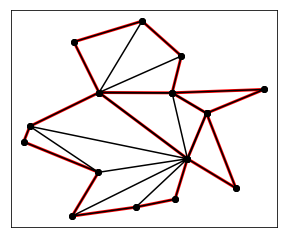

In [353]:
# Visualize result
original_quality_matrix,_=quality_matrix(procrustes_contour)
ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
triangulate(procrustes_contour,ordered_matrix)


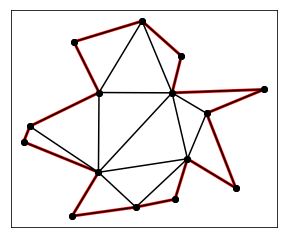

In [354]:
# 
shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
triangulated=triangle.triangulate(shape,'pq0')
plot.plot(plt.axes(), **triangulated)


In [47]:
# Timing procedure seperately

start_time=time.time()
# Perform procrustes
time1=time.time()
procrustes_contour=apply_procrustes(contour)
procrustes_time=time.time() - time1
print("Elapsed time for applying procrustes --- %s seconds ---" % (procrustes_time))


procrustes_contour=procrustes_contour.reshape(2*contour.shape[0]).reshape(1,-1)



# Project to space 
time2=time.time()
contour_transformed=pca.transform(procrustes_contour)
projection_time=time.time() - time2
print("Elapsed time for projection --- %s seconds ---" % (projection_time))


# Fire to network
time3=time.time()
input_contour=Variable(torch.from_numpy(contour_transformed).type(torch.FloatTensor)).cuda()
predicted_quality_matrix=network9(input_contour)
network_time=time.time() - time3
print("Elapsed time for getting quality matrix from neural net --- %s seconds ---" % (network_time))

predicted_quality_matrix=predicted_quality_matrix.cpu()
predicted_quality_matrix=predicted_quality_matrix.data[0].numpy().reshape(9,9)
procrustes_contour=procrustes_contour.reshape(9,2)


# Calculating quality matrix
time4=time.time()
original_quality_matrix,_=quality_matrix(procrustes_contour)
calculation_quality_matrix_time=time.time() - time4
print("Elapsed time for calculating original quality matrix  --- %s seconds ---" % (calculation_quality_matrix_time))


# Ordering quality matrix
time5=time.time()
ordered_matrix=order_quality_matrix(original_quality_matrix,procrustes_contour)
ordering_matrix_time=time.time() - time5
print("Elapsed time for ordering the quality matrix  --- %s seconds ---" % (ordering_matrix_time))


# Triangulation
time6=time.time()
triangulate(procrustes_contour,ordered_matrix)
triangulation_time=time.time() - time6
print("Elapsed time to triangulate according to matrix   --- %s seconds ---" % (triangulation_time))




print("Total time  of triangulation with calculation of matrix :   --- %s seconds ---" % ( (procrustes_time+calculation_quality_matrix_time
                                                                                      +ordering_matrix_time+triangulation_time)))

print("Total time  of triangulation using neural network :   --- %s seconds ---" % ( (procrustes_time+projection_time
                                                                                      +network_time+triangulation_time)))



Elapsed time for applying procrustes --- 0.0009884834289550781 seconds ---


D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:93: RuntimeWarning: invalid value encountered in true_divide
D:\Users\papagian\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: RuntimeWarning: invalid value encountered in true_divide


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [256]:
#  Time using the triangle module for meshing 
time7=time.time()
shape=dict(vertices=procrustes_contour,segments=get_contour_edges(procrustes_contour))
t = triangle.triangulate(shape, 'pq0')
plot.plot(plt.axes(), **t)
print("Elapsed time to triangulate using triangle module   --- %s seconds ---" % (time.time() - time7))


ValueError: Input must have at least three input vertices.

In [147]:
times4=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(4,4)
    times4[j]=time_elapsed
times5=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(5,5)
    times5[j]=time_elapsed
    
times6=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(6,6)
    times6[j]=time_elapsed
    
times7=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(7,7)
    times7[j]=time_elapsed
    
times8=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(8,8)
    times8[j]=time_elapsed
    
times9=np.empty([20,9])
for j in range(20):
    time_elapsed=run_time_test(9,9)
    times9[j]=time_elapsed
    

Elapsed time for applying procrustes --- 0.00032223501011685585 seconds ---
Elapsed time for projection --- 0.0001631666941648291 seconds ---
Elapsed time for getting quality matrix from neural net --- 0.0006677795472569414 seconds ---
Elapsed time for calculating original quality matrix  --- 0.13363634011739123 seconds ---
Elapsed time for ordering the quality matrix  --- 0.0003150628472212702 seconds ---
Elapsed time to triangulate according to matrix   --- 0.0010122994899575133 seconds ---
Total time  of triangulation with calculation of matrix :   --- 0.13528593746468687 seconds ---
Total time  of triangulation using neural network :   --- 0.0021654807414961397 seconds ---
Elapsed time to triangulate using triangle module   --- 5.345530449285434e-05 seconds ---
Elapsed time for applying procrustes --- 0.00037115940313015017 seconds ---
Elapsed time for projection --- 0.0001813532489904901 seconds ---
Elapsed time for getting quality matrix from neural net --- 0.0007092756295605795 

KeyboardInterrupt: 

In [142]:
times_elapsed_mean=np.array([times4.mean(0),times5.mean(0),times6.mean(0),times7.mean(0),times8.mean(0),times9.mean(0)])
times_elapsed_std=np.array([times4.std(0),times5.std(0),times6.std(0),times7.std(0),times8.std(0),times9.std(0)])

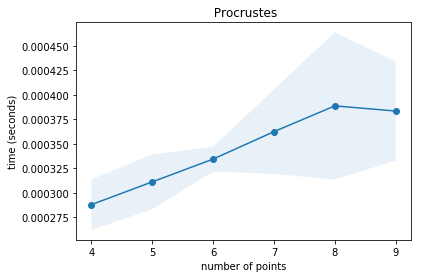

In [143]:
# Timing procrustes

procrustes_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,0],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,0]-times_elapsed_std[:,0],times_elapsed_mean[:,0]+times_elapsed_std[:,0],alpha=.1)
plt.title(' Procrustes')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

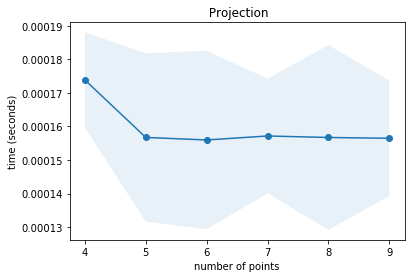

In [536]:
# Timing projection

projection_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,1],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,1]-times_elapsed_std[:,1],times_elapsed_mean[:,1]+times_elapsed_std[:,1],alpha=.1)

plt.title(' Projection')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

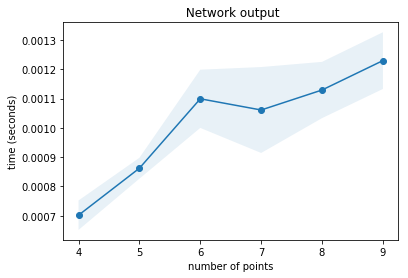

In [537]:
# Timing network output

network_time_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,2],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,2]-times_elapsed_std[:,2],times_elapsed_mean[:,2]+times_elapsed_std[:,2],alpha=.1)

plt.title(' Network output')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

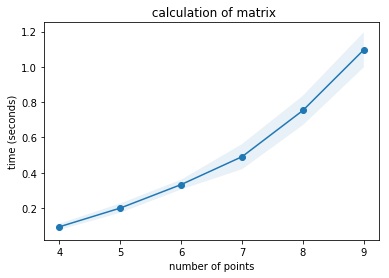

In [538]:
# Timing connection table

calculation_matrix_graph=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,3],marker='o')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,3]-times_elapsed_std[:,3],times_elapsed_mean[:,3]+times_elapsed_std[:,3],alpha=.1)

plt.title(' calculation of matrix')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')

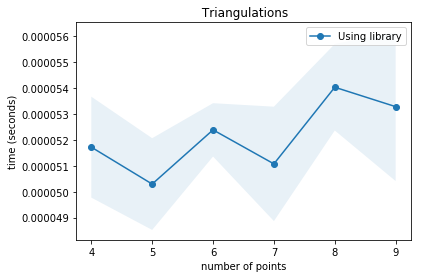

In [593]:
# Timing time to mesh with reference

triangulation_graph_with_library=plt.plot(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,8],marker='o',label='Using library')
plt.fill_between(np.array([4,5,6,7,8,9]),times_elapsed_mean[:,8]-times_elapsed_std[:,8],times_elapsed_mean[:,8]+times_elapsed_std[:,8],alpha=.1)

plt.legend()
plt.title(' Triangulations')
plt.xlabel('number of points')
plt.ylabel('time (seconds)')





In [182]:
nb_of_contours=100
contours=[generate_contour(i) for i in range(4,nb_of_contours) ]
processing_ctimes=np.empty([int(nb_of_contours-4)])
processing_timer=np.empty([int(nb_of_contours-4)])
processing_time=np.empty([int(nb_of_contours-4)])

In [183]:


for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]
    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=ctimer.start()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=ctimer.stop()
    remeshing_time=(ctimer.diff(time2,time1))*10**(-9)
    
    processing_ctimes[index]=remeshing_time


In [184]:

for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]

    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=timer()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=timer()
    remeshing_time=time2-time1
    
    processing_timer[index]=remeshing_time
    

In [185]:
for index,j in enumerate(range(4,nb_of_contours)):
    contour=contours[index]

    
    shape=dict(vertices=contour,segments=get_contour_edges(contour))
    
    time1=time.perf_counter()
    for i in range(1000):
        triangulated=triangle.triangulate(shape,'pq0')  
    time2=time.perf_counter()
    remeshing_time=time2-time1
    
    processing_time[index]=remeshing_time

(array([ 0.06760359,  0.05959082,  0.05308127,  0.05258083,  0.05258036,
         0.04657149,  0.05558467,  0.05308199,  0.05758834,  0.05458331,
         0.06159472,  0.05308104,  0.05308199,  0.0565865 ,  0.04506946,
         0.06059241,  0.05308175,  0.05108547,  0.06309676,  0.06059265,
         0.06309676,  0.063097  ,  0.06359696,  0.06710291,  0.07211065,
         0.06810474,  0.08412838,  0.07261181,  0.0751152 ,  0.08112407,
         0.07862043,  0.08863616,  0.1011548 ,  0.10365868,  0.07561564,
         0.07811999,  0.07862091,  0.07361293,  0.07711792,  0.07962227,
         0.076617  ,  0.07661748,  0.07661724,  0.0560863 ,  0.05458379,
         0.08563089,  0.08563137,  0.08763433,  0.08162498,  0.07862115,
         0.0826261 ,  0.08663273,  0.09564686,  0.08412933,  0.0906384 ,
         0.0951457 ,  0.10365939,  0.09814978,  0.11016965,  0.10466003,
         0.1076653 ,  0.11066961,  0.11016917,  0.12018418,  0.11116982,
         0.10516119,  0.11317372,  0.11317348,  0.1

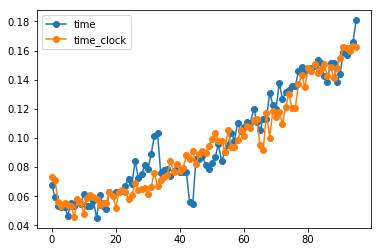

In [186]:
plt.plot(processing_time,marker='o',label='time')
#plt.plot(processing_ctimes,marker='x')
plt.plot(processing_timer,marker='o',label='time_clock')
plt.legend()
processing_time,processing_timer,processing_ctimes

# 

remeshing time : 0.0022776704


NameError: name 'triangulated' is not defined

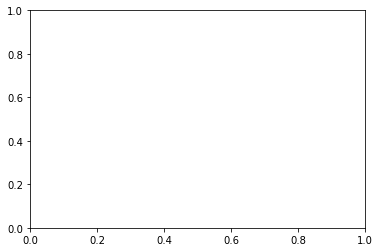

In [17]:
shape=dict(vertices=contour,segments=get_contour_edges(contour))

time1=timer()
Delaunay(contour)

time2=timer()

print("remeshing time : %.10f"%((time2-time1)))
plot.plot(plt.axes(), **triangulated)


In [29]:
from Delaunay_2d import Delaunay2d
from scipy.spatial import Delaunay


qualities=[]
for j in range(4,30):
    print(j)
    contour=get_reference_polygon(j)
    quality,_=quality_matrix(contour)
    qualities.append(quality)




4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [44]:
time_delaunay=[]
time_triangulation=[]


for index,j in enumerate(range(4,30)):
    nb_of_repetitions=100
    print("{} point polygon".format(j))
    contour = [np.array([i[0],i[1]]) for i in get_reference_polygon(j)]
    start=timer()
    for i in range(nb_of_repetitions):
        delaunay = Delaunay2d(contour)
    stop=timer()
    delaunay_remeshing_time=(stop-start)/nb_of_repetitions
    print("Elapsed time using Delaunay: %f"%(delaunay_remeshing_time))
    time_delaunay.append(delaunay_remeshing_time)
    
    
    contour=get_reference_polygon(j)
    quality=qualities[index]
    ordered_matrix=order_quality_matrix(quality,contour)
    start=timer()
    for i in range(nb_of_repetitions):
        pure_triangulate(contour,ordered_matrix,recursive=False)
    stop=timer()
    construction_from_matrix_time=(stop-start)/nb_of_repetitions
    print("Elapsed time using my method: %f"%(construction_from_matrix_time))
    time_triangulation.append(construction_from_matrix_time)
    


4 point polygon
Elapsed time using Delaunay: 0.000068
Elapsed time using my method: 0.000584
5 point polygon
Elapsed time using Delaunay: 0.000096
Elapsed time using my method: 0.000880
6 point polygon
Elapsed time using Delaunay: 0.000164
Elapsed time using my method: 0.001135
7 point polygon
Elapsed time using Delaunay: 0.000222
Elapsed time using my method: 0.001502
8 point polygon
Elapsed time using Delaunay: 0.000295
Elapsed time using my method: 0.002021
9 point polygon
Elapsed time using Delaunay: 0.000393
Elapsed time using my method: 0.002831
10 point polygon
Elapsed time using Delaunay: 0.000508
Elapsed time using my method: 0.003020
11 point polygon
Elapsed time using Delaunay: 0.000637
Elapsed time using my method: 0.004245
12 point polygon
Elapsed time using Delaunay: 0.000751
Elapsed time using my method: 0.004978
13 point polygon
Elapsed time using Delaunay: 0.000887
Elapsed time using my method: 0.007775
14 point polygon
Elapsed time using Delaunay: 0.001031
Elapsed tim

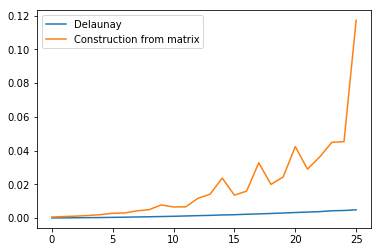

In [45]:
plt.plot(time_delaunay[:],label='Delaunay') 
#plt.plot(time_scipy_triangulation[:],label='Scipy  Delaunay')
plt.plot(time_triangulation[:],label='Construction from matrix')

plt.legend()